In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!apt-get install -y p7zip-full
!7z x "/content/drive/MyDrive/422的288.zip"


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-8).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.

7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/drive/MyDrive/                                 1 file, 487177439 bytes (465 MiB)

Extracting archive: /content/drive/MyDrive/422的288.zip
 11% 4096 Open               55% 20480 Open               --
Path = /content/drive/MyDrive/422的288.zip
Type = zip
Physical Size = 487177439
Embedded Stub Size = 4
64-bit = +
Total Physical Size = 8561212639
Multivolume = +
Volume Index = 11
Volumes = 12

  0%    

In [4]:
!pip install pydicom numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 58.9 MB/s eta 0:00:00


In [5]:
!pip install SimpleITK numpy tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 10.4 MB/s eta 0:00:00


In [9]:
import os
import pydicom
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def is_dicom_file(filename):
    return filename.lower().endswith('.dcm') or filename.lower().endswith('.ima')

def load_scan(dicom_folder):
    files = [os.path.join(dicom_folder, f) for f in os.listdir(dicom_folder) if is_dicom_file(f)]
    slices = []
    for f in files:
        try:
            ds = pydicom.dcmread(f, force=True)
            if hasattr(ds, 'ImagePositionPatient'):
                slices.append(ds)
        except Exception as e:
            continue
    if len(slices) == 0:
        return None, None
    slices.sort(key=lambda x: float(x.ImagePositionPatient[2]))
    images = []
    for s in slices:
        img = s.pixel_array.astype(np.float32)
        slope = float(getattr(s, 'RescaleSlope', 1.0))
        intercept = float(getattr(s, 'RescaleIntercept', 0.0))
        img = img * slope + intercept
        images.append(img)
    images = np.stack(images)
    return images, slices

def get_lung_slices_v2(img, threshold=-600, min_lung_percent=0.2, central_ratio=0.6):
    # 只统计中央区域的黑色像素比例
    N, H, W = img.shape
    h0 = int(H * (1 - central_ratio) / 2)
    h1 = int(H - h0)
    w0 = int(W * (1 - central_ratio) / 2)
    w1 = int(W - w0)
    lung_indices = []
    percents = []
    for i in range(N):
        patch = img[i, h0:h1, w0:w1]
        lung_pixel_count = np.sum(patch < threshold)
        percent = lung_pixel_count / patch.size
        percents.append(percent)
        if percent > min_lung_percent:
            lung_indices.append(i)
    # 找最大连续段
    if not lung_indices:
        return [], percents
    max_len = 0
    max_range = (0, 0)
    cur_start = lung_indices[0]
    cur_len = 1
    for j in range(1, len(lung_indices)):
        if lung_indices[j] == lung_indices[j-1]+1:
            cur_len += 1
        else:
            if cur_len > max_len:
                max_len = cur_len
                max_range = (cur_start, lung_indices[j-1])
            cur_start = lung_indices[j]
            cur_len = 1
    # 最后一个段落
    if cur_len > max_len:
        max_len = cur_len
        max_range = (cur_start, lung_indices[-1])
    # 返回最大连续段索引
    final_indices = list(range(max_range[0], max_range[1]+1))
    return final_indices, percents

root = '/content/422的288'
lung_df = pd.read_csv('/content/______CT__.csv')

output_folder = 'output_npy1'
os.makedirs(output_folder, exist_ok=True)

for rel_path in lung_df['File Location']:
    dicom_folder = os.path.join(root, rel_path.lstrip('.\\').replace('\\', os.sep).replace('/', os.sep))
    if not os.path.isdir(dicom_folder):
        print(f"Skip {dicom_folder}: Not a valid folder")
        continue
    try:
        img, slices = load_scan(dicom_folder)
        if img is None:
            print(f"Skip {dicom_folder}: no valid DICOM slices")
            continue
        print(f"{rel_path} HU min={img.min():.1f}, max={img.max():.1f}, shape={img.shape}")
        # --------- spacing获取 -----------
        s0 = slices[0]
        pixel_spacing = [float(x) for x in getattr(s0, 'PixelSpacing', [1.0, 1.0])]
        slice_thickness = float(getattr(s0, 'SliceThickness', 1.0))
        spacing = [slice_thickness, pixel_spacing[0], pixel_spacing[1]]  # [z, y, x]

        # --------- 升级版只保留最大肺slice段 -----------
        lung_slice_indices, percents = get_lung_slices_v2(img, threshold=-600, min_lung_percent=0.2, central_ratio=0.6)
        print(f"Black percent per slice (central region): {[round(p,2) for p in percents]}")
        if len(lung_slice_indices) == 0:
            print(f"Skip {dicom_folder}: no lung slices detected")
            continue
        img_lung_only = img[lung_slice_indices]

        # 保存npy和spacing
        file_name = rel_path.lstrip('.\\').replace('\\', '__').replace('/', '__').replace('.', '')
        out_path = os.path.join(output_folder, f"{file_name}.npy")
        out_spacing = os.path.join(output_folder, f"{file_name}_spacing.npy")
        np.save(out_path, img_lung_only)
        np.save(out_spacing, np.array(spacing))
        print(f"Saved: {out_path}, shape={img_lung_only.shape}, spacing={spacing}")
    except Exception as e:
        print(f"Skip {dicom_folder}: {e}")


.\NSCLC-Radiomics\LUNG1-003\01-01-2014-StudyID-NA-34270\1.000000-NA-28595 HU min=-1024.0, max=3071.0, shape=(107, 512, 512)
Black percent per slice (central region): [np.float64(0.17), np.float64(0.17), np.float64(0.17), np.float64(0.17), np.float64(0.18), np.float64(0.18), np.float64(0.18), np.float64(0.19), np.float64(0.2), np.float64(0.21), np.float64(0.21), np.float64(0.22), np.float64(0.22), np.float64(0.23), np.float64(0.24), np.float64(0.24), np.float64(0.25), np.float64(0.25), np.float64(0.26), np.float64(0.27), np.float64(0.28), np.float64(0.29), np.float64(0.31), np.float64(0.34), np.float64(0.36), np.float64(0.35), np.float64(0.35), np.float64(0.35), np.float64(0.35), np.float64(0.35), np.float64(0.35), np.float64(0.35), np.float64(0.37), np.float64(0.38), np.float64(0.39), np.float64(0.39), np.float64(0.38), np.float64(0.39), np.float64(0.39), np.float64(0.4), np.float64(0.41), np.float64(0.4), np.float64(0.4), np.float64(0.39), np.float64(0.4), np.float64(0.4), np.float64(

In [10]:
import os
import numpy as np
import SimpleITK as sitk
from tqdm import tqdm

# 设定路径
raw_folder = '/content/output_npy1'
save_folder = '/content/processed2'
os.makedirs(save_folder, exist_ok=True)

# 目标spacing和shape
target_spacing = [1.0, 1.0, 1.0]
target_shape = [16, 128, 128]

def resample_to_spacing(img, old_spacing, target_spacing):
    image = sitk.GetImageFromArray(img)
    image.SetSpacing(old_spacing)
    original_size = np.array(image.GetSize(), dtype=np.int16)
    original_spacing = np.array(image.GetSpacing())
    new_spacing = np.array(target_spacing)
    new_size = (original_size * (original_spacing / new_spacing)).astype(np.int16)
    resample = sitk.ResampleImageFilter()
    resample.SetOutputSpacing(list(new_spacing))
    resample.SetSize([int(sz) for sz in new_size])
    resample.SetOutputDirection(image.GetDirection())
    resample.SetOutputOrigin(image.GetOrigin())
    resample.SetInterpolator(sitk.sitkLinear)
    resampled_image = resample.Execute(image)
    out = sitk.GetArrayFromImage(resampled_image)
    return out

def center_crop_or_pad(img, target_shape):
    result = np.zeros(target_shape, dtype=img.dtype)
    z, y, x = img.shape
    tz, ty, tx = target_shape
    sz, sy, sx = min(z, tz), min(y, ty), min(x, tx)
    z_start = (tz-sz)//2
    y_start = (ty-sy)//2
    x_start = (tx-sx)//2
    result[z_start:z_start+sz, y_start:y_start+sy, x_start:x_start+sx] = \
        img[(z-sz)//2:(z-sz)//2+sz, (y-sy)//2:(y-sy)//2+sy, (x-sx)//2:(x-sx)//2+sx]
    return result

npy_list = [f for f in os.listdir(raw_folder) if f.endswith('.npy') and not f.endswith('_spacing.npy')]

for fname in tqdm(npy_list):
    fpath = os.path.join(raw_folder, fname)
    arr = np.load(fpath)
    # 自动配对spacing文件
    spacing_file = os.path.join(raw_folder, fname.replace('.npy', '_spacing.npy'))
    if os.path.exists(spacing_file):
        old_spacing = np.load(spacing_file).tolist()
    else:
        old_spacing = [1.0, 1.0, 1.0]  # 用1.0更安全（避免体积比例错位）

    # 体素重采样
    arr_rs = resample_to_spacing(arr, old_spacing, target_spacing)

    # 尺寸归一化
    arr_out = center_crop_or_pad(arr_rs, target_shape)

    # 保存
    save_name = os.path.join(save_folder, fname)
    np.save(save_name, arr_out)
    print(f"{fname}: {arr.shape} -> {arr_rs.shape} -> {arr_out.shape}, spacing used: {old_spacing}")

print('全部处理完成！')


  0%|          | 1/288 [00:03<17:26,  3.65s/it]

NSCLC-Radiomics__LUNG1-017__01-01-2014-StudyID-NA-37586__1000000-NA-06844.npy: (123, 512, 512) -> (120, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.977, 0.977]


  1%|          | 2/288 [00:07<17:34,  3.69s/it]

NSCLC-Radiomics__LUNG1-074__01-01-2014-StudyID-NA-96746__1000000-NA-75286.npy: (94, 512, 512) -> (91, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.977, 0.977]


  1%|          | 3/288 [00:12<19:35,  4.12s/it]

NSCLC-Radiomics__LUNG1-183__06-07-2007-StudyID-NA-82506__0000000-NA-48701.npy: (109, 512, 512) -> (106, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


  1%|▏         | 4/288 [00:14<16:30,  3.49s/it]

NSCLC-Radiomics__LUNG1-363__04-30-2010-NA-NA-46947__0000000-NA-83396.npy: (70, 512, 512) -> (68, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


  2%|▏         | 5/288 [00:17<14:49,  3.14s/it]

NSCLC-Radiomics__LUNG1-410__07-08-2010-NA-NA-60028__0000000-NA-33774.npy: (91, 512, 512) -> (88, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


  2%|▏         | 6/288 [00:19<13:37,  2.90s/it]

NSCLC-Radiomics__LUNG1-139__11-25-2006-StudyID-NA-87335__2000000-NA-97896.npy: (89, 512, 512) -> (86, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


  2%|▏         | 7/288 [00:22<13:02,  2.78s/it]

NSCLC-Radiomics__LUNG1-135__05-24-2010-NA-NA-73105__0000000-NA-57306.npy: (93, 512, 512) -> (90, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


  3%|▎         | 8/288 [00:26<15:11,  3.25s/it]

NSCLC-Radiomics__LUNG1-409__06-17-2010-NA-NA-58404__0000000-NA-18868.npy: (126, 512, 512) -> (123, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


  3%|▎         | 9/288 [00:31<18:02,  3.88s/it]

NSCLC-Radiomics__LUNG1-067__10-31-2005-NA-NA-57192__0000000-NA-54616.npy: (176, 512, 512) -> (171, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


  3%|▎         | 10/288 [00:35<17:27,  3.77s/it]

NSCLC-Radiomics__LUNG1-330__04-03-2009-NA-NA-46378__0000000-NA-75755.npy: (134, 512, 512) -> (130, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


  4%|▍         | 11/288 [00:37<15:54,  3.45s/it]

NSCLC-Radiomics__LUNG1-082__02-22-2006-StudyID-NA-33357__0000000-NA-77378.npy: (103, 512, 512) -> (100, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


  4%|▍         | 12/288 [00:41<16:26,  3.57s/it]

NSCLC-Radiomics__LUNG1-267__06-21-2008-StudyID-NA-57835__0000000-NA-72721.npy: (100, 512, 512) -> (97, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


  5%|▍         | 13/288 [00:44<14:58,  3.27s/it]

NSCLC-Radiomics__LUNG1-339__05-09-2009-StudyID-NA-94249__0000000-NA-03170.npy: (99, 512, 512) -> (96, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


  5%|▍         | 14/288 [00:47<14:29,  3.17s/it]

NSCLC-Radiomics__LUNG1-033__11-25-2004-StudyID-NA-23342__1000000-NA-00262.npy: (113, 512, 512) -> (110, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.977, 0.977]


  5%|▌         | 15/288 [00:49<13:24,  2.95s/it]

NSCLC-Radiomics__LUNG1-217__01-23-2008-StudyID-NA-12538__0000000-NA-36528.npy: (94, 512, 512) -> (91, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


  6%|▌         | 16/288 [00:52<12:49,  2.83s/it]

NSCLC-Radiomics__LUNG1-169__05-31-2007-StudyID-NA-97930__0000000-NA-73277.npy: (97, 512, 512) -> (94, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


  6%|▌         | 17/288 [00:54<12:30,  2.77s/it]

NSCLC-Radiomics__LUNG1-342__07-05-2009-StudyID-NA-33638__0000000-NA-01555.npy: (67, 512, 512) -> (65, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


  6%|▋         | 18/288 [00:58<13:09,  2.92s/it]

NSCLC-Radiomics__LUNG1-283__08-04-2008-StudyID-NA-17254__0000000-NA-81391.npy: (108, 512, 512) -> (105, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


  7%|▋         | 19/288 [01:01<13:48,  3.08s/it]

NSCLC-Radiomics__LUNG1-088__01-25-2006-StudyID-NA-70904__1000000-NA-22003.npy: (123, 512, 512) -> (120, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.977, 0.977]


  7%|▋         | 20/288 [01:04<13:44,  3.08s/it]

NSCLC-Radiomics__LUNG1-107__04-06-2006-StudyID-NA-19684__1000000-NA-21832.npy: (116, 512, 512) -> (113, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.977, 0.977]


  7%|▋         | 21/288 [01:09<16:16,  3.66s/it]

NSCLC-Radiomics__LUNG1-071__02-04-2006-StudyID-NA-35606__0000000-NA-40760.npy: (135, 512, 512) -> (131, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


  8%|▊         | 22/288 [01:11<14:19,  3.23s/it]

NSCLC-Radiomics__LUNG1-417__07-22-2010-NA-NA-22742__0000000-NA-27827.npy: (87, 512, 512) -> (84, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


  8%|▊         | 23/288 [01:15<14:34,  3.30s/it]

NSCLC-Radiomics__LUNG1-259__06-13-2008-StudyID-NA-59577__0000000-NA-49143.npy: (130, 512, 512) -> (126, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


  8%|▊         | 24/288 [01:17<12:43,  2.89s/it]

NSCLC-Radiomics__LUNG1-345__05-30-2009-StudyID-NA-32193__0000000-NA-73547.npy: (76, 512, 512) -> (74, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


  9%|▊         | 25/288 [01:19<11:30,  2.63s/it]

NSCLC-Radiomics__LUNG1-367__03-03-2010-NA-NA-79271__0000000-NA-70950.npy: (78, 512, 512) -> (76, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


  9%|▉         | 26/288 [01:22<11:48,  2.70s/it]

NSCLC-Radiomics__LUNG1-035__01-01-2014-StudyID-NA-67281__1000000-NA-25615.npy: (81, 512, 512) -> (79, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.977, 0.977]


  9%|▉         | 27/288 [01:24<11:56,  2.75s/it]

NSCLC-Radiomics__LUNG1-343__05-14-2009-StudyID-NA-95338__0000000-NA-84394.npy: (80, 512, 512) -> (78, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 10%|▉         | 28/288 [01:28<13:09,  3.04s/it]

NSCLC-Radiomics__LUNG1-316__11-28-2008-NA-NA-76361__0000000-NA-36691.npy: (134, 512, 512) -> (130, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 10%|█         | 29/288 [01:31<12:16,  2.84s/it]

NSCLC-Radiomics__LUNG1-220__12-20-2007-StudyID-NA-41451__0000000-NA-64549.npy: (94, 512, 512) -> (91, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 10%|█         | 30/288 [01:34<13:32,  3.15s/it]

NSCLC-Radiomics__LUNG1-258__06-20-2008-StudyID-NA-37077__0000000-NA-52059.npy: (134, 512, 512) -> (130, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 11%|█         | 31/288 [01:39<14:45,  3.45s/it]

NSCLC-Radiomics__LUNG1-286__11-23-2008-StudyID-NA-78742__0000000-NA-67379.npy: (114, 512, 512) -> (111, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 11%|█         | 32/288 [01:42<14:57,  3.51s/it]

NSCLC-Radiomics__LUNG1-324__03-12-2009-NA-NA-65810__0000000-NA-51609.npy: (134, 512, 512) -> (130, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 11%|█▏        | 33/288 [01:45<13:53,  3.27s/it]

NSCLC-Radiomics__LUNG1-115__07-28-2006-StudyID-NA-45713__0000000-NA-30284.npy: (106, 512, 512) -> (103, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 12%|█▏        | 34/288 [01:47<12:39,  2.99s/it]

NSCLC-Radiomics__LUNG1-228__01-01-2014-StudyID-NA-77539__1000000-NA-62367.npy: (90, 512, 512) -> (87, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9766, 0.9766]


 12%|█▏        | 35/288 [01:53<15:40,  3.72s/it]

NSCLC-Radiomics__LUNG1-296__10-03-2008-StudyID-NA-14251__0000000-NA-37234.npy: (133, 512, 512) -> (129, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 12%|█▎        | 36/288 [01:56<15:01,  3.58s/it]

NSCLC-Radiomics__LUNG1-155__01-01-2014-StudyID-NA-26744__1000000-NA-04804.npy: (121, 512, 512) -> (118, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.977, 0.977]


 13%|█▎        | 37/288 [01:58<13:26,  3.21s/it]

NSCLC-Radiomics__LUNG1-205__11-21-2007-StudyID-NA-09585__0000000-NA-40479.npy: (94, 512, 512) -> (91, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 13%|█▎        | 38/288 [02:03<14:56,  3.58s/it]

NSCLC-Radiomics__LUNG1-069__12-16-2005-StudyID-NA-43687__1000000-NA-13296.npy: (153, 512, 512) -> (149, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.977, 0.977]


 14%|█▎        | 39/288 [02:08<17:32,  4.23s/it]

NSCLC-Radiomics__LUNG1-096__02-03-2006-StudyID-NA-11532__0000000-NA-49379.npy: (176, 512, 512) -> (171, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 14%|█▍        | 40/288 [02:11<15:41,  3.80s/it]

NSCLC-Radiomics__LUNG1-023__01-01-2014-StudyID-NA-01819__1000000-NA-72594.npy: (111, 512, 512) -> (108, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.977, 0.977]


 14%|█▍        | 41/288 [02:15<15:13,  3.70s/it]

NSCLC-Radiomics__LUNG1-257__06-02-2008-StudyID-NA-05516__0000000-NA-78432.npy: (134, 512, 512) -> (130, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 15%|█▍        | 42/288 [02:20<16:42,  4.08s/it]

NSCLC-Radiomics__LUNG1-290__08-25-2008-StudyID-NA-82911__0000000-NA-97623.npy: (134, 512, 512) -> (130, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 15%|█▍        | 43/288 [02:23<16:04,  3.94s/it]

NSCLC-Radiomics__LUNG1-232__04-21-2008-StudyID-NA-83266__0000000-NA-92625.npy: (136, 512, 512) -> (132, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 15%|█▌        | 44/288 [02:26<14:09,  3.48s/it]

NSCLC-Radiomics__LUNG1-360__02-24-2010-NA-NA-67335__0000000-NA-15854.npy: (96, 512, 512) -> (93, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 16%|█▌        | 45/288 [02:29<13:49,  3.41s/it]

NSCLC-Radiomics__LUNG1-179__05-13-2007-StudyID-NA-86662__0000000-NA-58886.npy: (123, 512, 512) -> (120, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 16%|█▌        | 46/288 [02:31<12:23,  3.07s/it]

NSCLC-Radiomics__LUNG1-215__11-23-2007-StudyID-NA-70193__0000000-NA-45443.npy: (75, 512, 512) -> (73, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 16%|█▋        | 47/288 [02:36<14:07,  3.52s/it]

NSCLC-Radiomics__LUNG1-337__05-04-2009-StudyID-NA-15683__0000000-NA-68848.npy: (134, 512, 512) -> (130, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 17%|█▋        | 48/288 [02:39<14:15,  3.56s/it]

NSCLC-Radiomics__LUNG1-048__04-13-2006-StudyID-NA-58189__0000000-NA-88459.npy: (135, 512, 512) -> (131, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 17%|█▋        | 49/288 [02:43<13:59,  3.51s/it]

NSCLC-Radiomics__LUNG1-007__05-28-2010-NA-NA-36277__0000000-NA-67872.npy: (129, 512, 512) -> (125, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 17%|█▋        | 50/288 [02:48<15:33,  3.92s/it]

NSCLC-Radiomics__LUNG1-202__05-29-2010-NA-NA-47068__0000000-NA-64821.npy: (134, 512, 512) -> (130, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 18%|█▊        | 51/288 [02:50<13:41,  3.46s/it]

NSCLC-Radiomics__LUNG1-276__08-09-2008-StudyID-NA-11607__0000000-NA-50929.npy: (94, 512, 512) -> (91, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 18%|█▊        | 52/288 [02:53<12:30,  3.18s/it]

NSCLC-Radiomics__LUNG1-331__05-04-2009-StudyID-NA-03147__0000000-NA-58486.npy: (99, 512, 512) -> (96, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 18%|█▊        | 53/288 [02:56<12:59,  3.32s/it]

NSCLC-Radiomics__LUNG1-251__04-26-2008-NA-NA-77891__0000000-NA-87363.npy: (134, 512, 512) -> (130, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 19%|█▉        | 54/288 [02:59<12:27,  3.20s/it]

NSCLC-Radiomics__LUNG1-050__01-01-2014-NA-NA-47268__1000000-NA-16464.npy: (104, 512, 512) -> (101, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.977, 0.977]


 19%|█▉        | 55/288 [03:02<12:23,  3.19s/it]

NSCLC-Radiomics__LUNG1-271__07-05-2008-StudyID-NA-19150__0000000-NA-04105.npy: (83, 512, 512) -> (81, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 19%|█▉        | 56/288 [03:06<12:53,  3.34s/it]

NSCLC-Radiomics__LUNG1-084__01-05-2006-StudyID-NA-94731__0000000-NA-90798.npy: (135, 512, 512) -> (131, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 20%|█▉        | 57/288 [03:09<12:51,  3.34s/it]

NSCLC-Radiomics__LUNG1-162__04-12-2007-StudyID-NA-21249__0000000-NA-72433.npy: (124, 512, 512) -> (121, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 20%|██        | 58/288 [03:13<13:19,  3.47s/it]

NSCLC-Radiomics__LUNG1-164__03-07-2007-StudyID-NA-67128__0000000-NA-66217.npy: (134, 512, 512) -> (130, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 20%|██        | 59/288 [03:17<13:35,  3.56s/it]

NSCLC-Radiomics__LUNG1-043__01-01-2014-StudyID-NA-76764__1000000-NA-04269.npy: (103, 512, 512) -> (100, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.977, 0.977]


 21%|██        | 60/288 [03:21<13:34,  3.57s/it]

NSCLC-Radiomics__LUNG1-277__08-14-2008-StudyID-NA-12722__0000000-NA-50975.npy: (130, 512, 512) -> (126, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 21%|██        | 61/288 [03:23<12:37,  3.34s/it]

NSCLC-Radiomics__LUNG1-362__02-20-2010-NA-NA-75493__0000000-NA-94838.npy: (108, 512, 512) -> (105, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 22%|██▏       | 62/288 [03:25<11:08,  2.96s/it]

NSCLC-Radiomics__LUNG1-012__01-01-2014-StudyID-NA-42151__1000000-NA-36694.npy: (82, 512, 512) -> (80, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.977, 0.977]


 22%|██▏       | 63/288 [03:26<08:42,  2.32s/it]

NSCLC-Radiomics__LUNG1-333__04-24-2009-NA-NA-45030__0000000-NA-96279.npy: (34, 512, 512) -> (33, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 22%|██▏       | 64/288 [03:31<10:56,  2.93s/it]

NSCLC-Radiomics__LUNG1-206__10-06-2007-StudyID-NA-84710__0000000-NA-95661.npy: (107, 512, 512) -> (104, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 23%|██▎       | 65/288 [03:34<11:43,  3.16s/it]

NSCLC-Radiomics__LUNG1-361__04-11-2010-NA-NA-81795__0000000-NA-56193.npy: (134, 512, 512) -> (130, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 23%|██▎       | 66/288 [03:38<12:09,  3.29s/it]

NSCLC-Radiomics__LUNG1-001__09-18-2008-StudyID-NA-69331__0000000-NA-82046.npy: (134, 512, 512) -> (130, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 23%|██▎       | 67/288 [03:42<12:35,  3.42s/it]

NSCLC-Radiomics__LUNG1-288__09-11-2008-StudyID-NA-92514__0000000-NA-45053.npy: (132, 512, 512) -> (128, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 24%|██▎       | 68/288 [03:45<12:43,  3.47s/it]

NSCLC-Radiomics__LUNG1-072__04-22-2006-StudyID-NA-70523__0000000-NA-76342.npy: (102, 512, 512) -> (99, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 24%|██▍       | 69/288 [03:49<12:40,  3.47s/it]

NSCLC-Radiomics__LUNG1-114__05-11-2006-StudyID-NA-27216__0000000-NA-15647.npy: (129, 512, 512) -> (125, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 24%|██▍       | 70/288 [03:49<09:34,  2.64s/it]

NSCLC-Radiomics__LUNG1-149__01-01-2014-StudyID-NA-90701__1000000-NA-69519.npy: (43, 512, 512) -> (30, 368, 1536) -> (16, 128, 128), spacing used: [3.0, 0.7207, 0.7207]


 25%|██▍       | 71/288 [03:51<08:42,  2.41s/it]

NSCLC-Radiomics__LUNG1-284__08-21-2008-StudyID-NA-73519__0000000-NA-22781.npy: (74, 512, 512) -> (72, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 25%|██▌       | 72/288 [03:55<10:10,  2.82s/it]

NSCLC-Radiomics__LUNG1-344__06-08-2009-NA-NA-79985__0000000-NA-64140.npy: (134, 512, 512) -> (130, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 25%|██▌       | 73/288 [03:59<11:38,  3.25s/it]

NSCLC-Radiomics__LUNG1-208__10-11-2007-StudyID-NA-72398__0000000-NA-87404.npy: (116, 512, 512) -> (113, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 26%|██▌       | 74/288 [04:02<11:03,  3.10s/it]

NSCLC-Radiomics__LUNG1-085__01-14-2006-StudyID-NA-78863__1000000-NA-24696.npy: (106, 512, 512) -> (103, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.977, 0.977]


 26%|██▌       | 75/288 [04:04<10:06,  2.85s/it]

NSCLC-Radiomics__LUNG1-226__02-09-2008-StudyID-NA-35479__0000000-NA-54388.npy: (89, 512, 512) -> (86, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 26%|██▋       | 76/288 [04:08<10:41,  3.02s/it]

NSCLC-Radiomics__LUNG1-289__08-23-2008-StudyID-NA-97557__0000000-NA-98684.npy: (125, 512, 512) -> (122, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 27%|██▋       | 77/288 [04:13<12:59,  3.70s/it]

NSCLC-Radiomics__LUNG1-320__05-07-2009-StudyID-NA-86012__0000000-NA-28564.npy: (131, 512, 512) -> (127, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 27%|██▋       | 78/288 [04:17<12:49,  3.67s/it]

NSCLC-Radiomics__LUNG1-364__02-27-2010-NA-NA-09037__0000000-NA-10537.npy: (134, 512, 512) -> (130, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 27%|██▋       | 79/288 [04:20<12:26,  3.57s/it]

NSCLC-Radiomics__LUNG1-194__09-24-2007-StudyID-NA-07383__1000000-NA-58466.npy: (127, 512, 512) -> (124, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.977, 0.977]


 28%|██▊       | 80/288 [04:22<10:59,  3.17s/it]

NSCLC-Radiomics__LUNG1-195__07-30-2007-StudyID-NA-11824__0000000-NA-22913.npy: (90, 512, 512) -> (87, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 28%|██▊       | 81/288 [04:25<11:02,  3.20s/it]

NSCLC-Radiomics__LUNG1-177__07-08-2007-StudyID-NA-83992__1000000-NA-83231.npy: (94, 512, 512) -> (91, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.977, 0.977]


 28%|██▊       | 82/288 [04:30<12:19,  3.59s/it]

NSCLC-Radiomics__LUNG1-031__01-01-2014-StudyID-NA-60542__1000000-NA-87690.npy: (153, 512, 512) -> (149, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.977, 0.977]


 29%|██▉       | 83/288 [04:33<11:22,  3.33s/it]

NSCLC-Radiomics__LUNG1-025__01-05-2005-StudyID-NA-11391__1000000-NA-17063.npy: (106, 512, 512) -> (103, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.977, 0.977]


 29%|██▉       | 84/288 [04:35<10:32,  3.10s/it]

NSCLC-Radiomics__LUNG1-147__01-31-2007-StudyID-NA-77949__0000000-NA-66506.npy: (99, 512, 512) -> (96, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 30%|██▉       | 85/288 [04:38<10:13,  3.02s/it]

NSCLC-Radiomics__LUNG1-034__01-01-2014-StudyID-NA-02272__1000000-NA-42573.npy: (95, 512, 512) -> (92, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.977, 0.977]


 30%|██▉       | 86/288 [04:43<11:42,  3.48s/it]

NSCLC-Radiomics__LUNG1-366__04-12-2010-NA-NA-44824__0000000-NA-58053.npy: (134, 512, 512) -> (130, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 30%|███       | 87/288 [04:46<11:07,  3.32s/it]

NSCLC-Radiomics__LUNG1-101__03-15-2006-StudyID-NA-27911__1000000-NA-55665.npy: (112, 512, 512) -> (109, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.977, 0.977]


 31%|███       | 88/288 [04:49<11:19,  3.40s/it]

NSCLC-Radiomics__LUNG1-268__06-29-2008-StudyID-NA-77442__0000000-NA-46443.npy: (132, 512, 512) -> (128, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 31%|███       | 89/288 [04:52<10:39,  3.22s/it]

NSCLC-Radiomics__LUNG1-234__02-08-2008-StudyID-NA-15406__0000000-NA-44690.npy: (94, 512, 512) -> (91, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 31%|███▏      | 90/288 [04:56<11:55,  3.62s/it]

NSCLC-Radiomics__LUNG1-091__01-27-2006-StudyID-NA-54545__1000000-NA-46531.npy: (135, 512, 512) -> (131, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.977, 0.977]


 32%|███▏      | 91/288 [04:59<10:39,  3.24s/it]

NSCLC-Radiomics__LUNG1-079__12-22-2005-StudyID-NA-39992__0000000-NA-57564.npy: (95, 512, 512) -> (92, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 32%|███▏      | 92/288 [05:01<09:08,  2.80s/it]

NSCLC-Radiomics__LUNG1-011__01-01-2014-StudyID-NA-64935__1000000-NA-64032.npy: (69, 512, 512) -> (67, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.977, 0.977]


 32%|███▏      | 93/288 [05:04<09:57,  3.06s/it]

NSCLC-Radiomics__LUNG1-419__07-17-2010-NA-NA-87475__0000000-NA-26917.npy: (134, 512, 512) -> (130, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 33%|███▎      | 94/288 [05:10<12:03,  3.73s/it]

NSCLC-Radiomics__LUNG1-421__07-17-2010-NA-NA-30075__0000000-NA-00327.npy: (134, 512, 512) -> (130, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 33%|███▎      | 95/288 [05:12<10:41,  3.32s/it]

NSCLC-Radiomics__LUNG1-221__12-27-2007-StudyID-NA-77670__0000000-NA-15772.npy: (94, 512, 512) -> (91, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 33%|███▎      | 96/288 [05:14<09:44,  3.05s/it]

NSCLC-Radiomics__LUNG1-384__03-21-2010-NA-NA-86252__0000000-NA-24848.npy: (93, 512, 512) -> (90, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 34%|███▎      | 97/288 [05:17<09:29,  2.98s/it]

NSCLC-Radiomics__LUNG1-125__01-01-2014-StudyID-NA-62598__1000000-NA-46685.npy: (107, 512, 512) -> (104, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.977, 0.977]


 34%|███▍      | 98/288 [05:22<11:00,  3.48s/it]

NSCLC-Radiomics__LUNG1-242__05-24-2008-StudyID-NA-01548__0000000-NA-03494.npy: (134, 512, 512) -> (130, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 34%|███▍      | 99/288 [05:26<11:18,  3.59s/it]

NSCLC-Radiomics__LUNG1-247__04-24-2008-StudyID-NA-85745__0000000-NA-59679.npy: (134, 512, 512) -> (130, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 35%|███▍      | 100/288 [05:28<09:41,  3.10s/it]

NSCLC-Radiomics__LUNG1-282__08-08-2008-StudyID-NA-37762__0000000-NA-64667.npy: (77, 512, 512) -> (75, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 35%|███▌      | 101/288 [05:30<09:02,  2.90s/it]

NSCLC-Radiomics__LUNG1-209__01-01-2014-StudyID-NA-14599__1000000-NA-45365.npy: (96, 512, 512) -> (93, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.977, 0.977]


 35%|███▌      | 102/288 [05:32<08:17,  2.68s/it]

NSCLC-Radiomics__LUNG1-317__12-03-2008-StudyID-NA-67637__0000000-NA-06034.npy: (84, 512, 512) -> (82, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 36%|███▌      | 103/288 [05:36<09:00,  2.92s/it]

NSCLC-Radiomics__LUNG1-224__12-13-2007-StudyID-NA-84005__0000000-NA-77372.npy: (93, 512, 512) -> (90, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 36%|███▌      | 104/288 [05:38<08:27,  2.76s/it]

NSCLC-Radiomics__LUNG1-009__01-01-2014-StudyID-NA-54035__1000000-NA-63984.npy: (78, 512, 512) -> (76, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.977, 0.977]


 36%|███▋      | 105/288 [05:42<09:03,  2.97s/it]

NSCLC-Radiomics__LUNG1-121__06-30-2006-StudyID-NA-05880__0000000-NA-76030.npy: (125, 512, 512) -> (122, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 37%|███▋      | 106/288 [05:45<09:31,  3.14s/it]

NSCLC-Radiomics__LUNG1-380__04-01-2010-NA-NA-08572__0000000-NA-85079.npy: (131, 512, 512) -> (127, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 37%|███▋      | 107/288 [05:48<08:50,  2.93s/it]

NSCLC-Radiomics__LUNG1-285__08-03-2008-StudyID-NA-05059__0000000-NA-50027.npy: (90, 512, 512) -> (87, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 38%|███▊      | 108/288 [05:52<10:23,  3.47s/it]

NSCLC-Radiomics__LUNG1-346__05-30-2009-NA-NA-51957__0000000-NA-45123.npy: (134, 512, 512) -> (130, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 38%|███▊      | 109/288 [05:54<09:15,  3.10s/it]

NSCLC-Radiomics__LUNG1-117__06-03-2006-StudyID-NA-67639__1000000-NA-08243.npy: (90, 512, 512) -> (87, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.977, 0.977]


 38%|███▊      | 110/288 [05:57<08:32,  2.88s/it]

NSCLC-Radiomics__LUNG1-010__01-01-2014-StudyID-NA-54264__1000000-NA-08510.npy: (91, 512, 512) -> (88, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.977, 0.977]


 39%|███▊      | 111/288 [05:59<08:14,  2.80s/it]

NSCLC-Radiomics__LUNG1-386__05-22-2010-NA-NA-06691__0000000-NA-06712.npy: (98, 512, 512) -> (95, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 39%|███▉      | 112/288 [06:03<09:14,  3.15s/it]

NSCLC-Radiomics__LUNG1-059__11-16-2005-StudyID-NA-77162__1000000-NA-57360.npy: (110, 512, 512) -> (107, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.977, 0.977]


 39%|███▉      | 113/288 [06:07<09:07,  3.13s/it]

NSCLC-Radiomics__LUNG1-350__07-17-2009-StudyID-NA-96972__0000000-NA-14282.npy: (104, 512, 512) -> (101, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 40%|███▉      | 114/288 [06:09<08:44,  3.01s/it]

NSCLC-Radiomics__LUNG1-068__01-01-2014-StudyID-NA-02929__1000000-NA-34906.npy: (105, 512, 512) -> (102, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.977, 0.977]


 40%|███▉      | 115/288 [06:13<09:14,  3.20s/it]

NSCLC-Radiomics__LUNG1-270__06-26-2008-StudyID-NA-10465__0000000-NA-13318.npy: (134, 512, 512) -> (130, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 40%|████      | 116/288 [06:18<10:25,  3.64s/it]

NSCLC-Radiomics__LUNG1-336__04-27-2009-NA-NA-25172__0000000-NA-20033.npy: (134, 512, 512) -> (130, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 41%|████      | 117/288 [06:21<10:28,  3.68s/it]

NSCLC-Radiomics__LUNG1-241__05-02-2008-StudyID-NA-66003__0000000-NA-04303.npy: (136, 512, 512) -> (132, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 41%|████      | 118/288 [06:25<10:13,  3.61s/it]

NSCLC-Radiomics__LUNG1-327__03-28-2009-NA-NA-61917__0000000-NA-80260.npy: (131, 512, 512) -> (127, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 41%|████▏     | 119/288 [06:27<09:09,  3.25s/it]

NSCLC-Radiomics__LUNG1-261__05-25-2008-StudyID-NA-05528__0000000-NA-62313.npy: (94, 512, 512) -> (91, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 42%|████▏     | 120/288 [06:30<08:38,  3.08s/it]

NSCLC-Radiomics__LUNG1-030__01-01-2014-StudyID-NA-40195__1000000-NA-81060.npy: (88, 512, 512) -> (85, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.977, 0.977]


 42%|████▏     | 121/288 [06:34<09:10,  3.30s/it]

NSCLC-Radiomics__LUNG1-148__01-13-2007-StudyID-NA-25055__0000000-NA-61616.npy: (108, 512, 512) -> (105, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 42%|████▏     | 122/288 [06:37<09:25,  3.41s/it]

NSCLC-Radiomics__LUNG1-369__02-25-2010-NA-NA-41022__0000000-NA-45194.npy: (134, 512, 512) -> (130, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 43%|████▎     | 123/288 [06:42<10:31,  3.83s/it]

NSCLC-Radiomics__LUNG1-093__04-13-2006-StudyID-NA-25111__0000000-NA-54643.npy: (176, 512, 512) -> (171, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 43%|████▎     | 124/288 [06:46<10:07,  3.71s/it]

NSCLC-Radiomics__LUNG1-243__04-14-2008-StudyID-NA-72904__0000000-NA-97022.npy: (94, 512, 512) -> (91, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 43%|████▎     | 125/288 [06:49<10:06,  3.72s/it]

NSCLC-Radiomics__LUNG1-325__03-22-2009-NA-NA-13387__0000000-NA-53444.npy: (134, 512, 512) -> (130, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 44%|████▍     | 126/288 [06:53<09:58,  3.69s/it]

NSCLC-Radiomics__LUNG1-396__05-01-2010-NA-NA-28227__0000000-NA-05554.npy: (134, 512, 512) -> (130, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 44%|████▍     | 127/288 [06:56<09:45,  3.64s/it]

NSCLC-Radiomics__LUNG1-291__08-25-2008-StudyID-NA-33948__0000000-NA-47372.npy: (134, 512, 512) -> (130, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 44%|████▍     | 128/288 [07:02<10:53,  4.09s/it]

NSCLC-Radiomics__LUNG1-233__02-07-2008-StudyID-NA-75540__0000000-NA-07863.npy: (134, 512, 512) -> (130, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 45%|████▍     | 129/288 [07:05<10:26,  3.94s/it]

NSCLC-Radiomics__LUNG1-300__10-11-2008-StudyID-NA-86802__0000000-NA-23856.npy: (134, 512, 512) -> (130, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 45%|████▌     | 130/288 [07:10<11:04,  4.20s/it]

NSCLC-Radiomics__LUNG1-038__01-01-2014-StudyID-NA-11498__1000000-NA-58734.npy: (176, 512, 512) -> (171, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.977, 0.977]


 45%|████▌     | 131/288 [07:14<10:49,  4.14s/it]

NSCLC-Radiomics__LUNG1-401__05-21-2010-NA-NA-21105__0000000-NA-81445.npy: (110, 512, 512) -> (107, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 46%|████▌     | 132/288 [07:17<09:58,  3.84s/it]

NSCLC-Radiomics__LUNG1-127__01-20-2007-StudyID-NA-33440__0000000-NA-17653.npy: (116, 512, 512) -> (113, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 46%|████▌     | 133/288 [07:19<08:29,  3.28s/it]

NSCLC-Radiomics__LUNG1-211__11-11-2007-StudyID-NA-97016__0000000-NA-16430.npy: (79, 512, 512) -> (77, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 47%|████▋     | 134/288 [07:22<07:52,  3.07s/it]

NSCLC-Radiomics__LUNG1-387__04-16-2010-NA-NA-38981__0000000-NA-54214.npy: (101, 512, 512) -> (98, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 47%|████▋     | 135/288 [07:25<08:22,  3.28s/it]

NSCLC-Radiomics__LUNG1-402__05-31-2010-NA-NA-57367__0000000-NA-34101.npy: (134, 512, 512) -> (130, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 47%|████▋     | 136/288 [07:29<08:45,  3.45s/it]

NSCLC-Radiomics__LUNG1-130__08-14-2006-StudyID-NA-58337__0000000-NA-60282.npy: (104, 512, 512) -> (101, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 48%|████▊     | 137/288 [07:33<08:51,  3.52s/it]

NSCLC-Radiomics__LUNG1-269__08-31-2008-StudyID-NA-27195__0000000-NA-30065.npy: (134, 512, 512) -> (130, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 48%|████▊     | 138/288 [07:35<08:00,  3.20s/it]

NSCLC-Radiomics__LUNG1-044__01-01-2014-StudyID-NA-08675__1000000-NA-41615.npy: (99, 512, 512) -> (96, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.977, 0.977]


 48%|████▊     | 139/288 [07:37<06:55,  2.79s/it]

NSCLC-Radiomics__LUNG1-229__01-03-2008-StudyID-NA-22809__0000000-NA-29880.npy: (72, 512, 512) -> (70, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 49%|████▊     | 140/288 [07:42<08:17,  3.36s/it]

NSCLC-Radiomics__LUNG1-056__05-23-2008-StudyID-NA-46060__0000000-NA-47214.npy: (134, 512, 512) -> (130, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 49%|████▉     | 141/288 [07:45<07:49,  3.20s/it]

NSCLC-Radiomics__LUNG1-061__11-24-2005-StudyID-NA-19108__1000000-NA-98344.npy: (100, 512, 512) -> (97, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.977, 0.977]


 49%|████▉     | 142/288 [07:47<07:06,  2.92s/it]

NSCLC-Radiomics__LUNG1-374__03-25-2010-NA-NA-06448__0000000-NA-76935.npy: (90, 512, 512) -> (87, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 50%|████▉     | 143/288 [07:51<07:36,  3.15s/it]

NSCLC-Radiomics__LUNG1-414__07-10-2010-NA-NA-66211__0000000-NA-70949.npy: (134, 512, 512) -> (130, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 50%|█████     | 144/288 [07:54<07:36,  3.17s/it]

NSCLC-Radiomics__LUNG1-124__09-28-2006-StudyID-NA-06637__0000000-NA-29869.npy: (111, 512, 512) -> (108, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 50%|█████     | 145/288 [07:59<08:32,  3.58s/it]

NSCLC-Radiomics__LUNG1-279__07-21-2008-NA-NA-29041__0000000-NA-81205.npy: (134, 512, 512) -> (130, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 51%|█████     | 146/288 [08:02<08:26,  3.57s/it]

NSCLC-Radiomics__LUNG1-377__03-04-2010-NA-NA-80035__0000000-NA-67530.npy: (134, 512, 512) -> (130, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 51%|█████     | 147/288 [08:05<08:02,  3.42s/it]

NSCLC-Radiomics__LUNG1-301__10-02-2008-NA-NA-22497__0000000-NA-23718.npy: (119, 512, 512) -> (116, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 51%|█████▏    | 148/288 [08:09<08:31,  3.65s/it]

NSCLC-Radiomics__LUNG1-292__11-08-2008-StudyID-NA-74317__0000000-NA-06426.npy: (125, 512, 512) -> (122, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 52%|█████▏    | 149/288 [08:12<07:57,  3.44s/it]

NSCLC-Radiomics__LUNG1-062__01-01-2014-StudyID-NA-45668__1000000-NA-07730.npy: (101, 512, 512) -> (98, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.977, 0.977]


 52%|█████▏    | 150/288 [08:15<07:20,  3.20s/it]

NSCLC-Radiomics__LUNG1-156__03-10-2007-StudyID-NA-32544__0000000-NA-72744.npy: (101, 512, 512) -> (98, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 52%|█████▏    | 151/288 [08:18<06:53,  3.02s/it]

NSCLC-Radiomics__LUNG1-275__09-18-2008-StudyID-NA-06365__0000000-NA-35628.npy: (99, 512, 512) -> (96, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 53%|█████▎    | 152/288 [08:20<06:26,  2.84s/it]

NSCLC-Radiomics__LUNG1-262__06-14-2008-StudyID-NA-35401__0000000-NA-52625.npy: (94, 512, 512) -> (91, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 53%|█████▎    | 153/288 [08:23<06:22,  2.83s/it]

NSCLC-Radiomics__LUNG1-057__01-01-2014-StudyID-NA-01906__1000000-NA-72474.npy: (80, 512, 512) -> (78, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.977, 0.977]


 53%|█████▎    | 154/288 [08:27<07:08,  3.19s/it]

NSCLC-Radiomics__LUNG1-351__06-01-2009-NA-NA-63603__0000000-NA-33943.npy: (130, 512, 512) -> (126, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 54%|█████▍    | 155/288 [08:29<06:36,  2.98s/it]

NSCLC-Radiomics__LUNG1-008__01-01-2014-StudyID-NA-52421__1000000-NA-44475.npy: (96, 512, 512) -> (93, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.977, 0.977]


 54%|█████▍    | 156/288 [08:33<07:00,  3.19s/it]

NSCLC-Radiomics__LUNG1-354__08-14-2009-NA-NA-28314__0000000-NA-73663.npy: (135, 512, 512) -> (131, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 55%|█████▍    | 157/288 [08:36<06:43,  3.08s/it]

NSCLC-Radiomics__LUNG1-192__09-08-2007-StudyID-NA-99803__0000000-NA-84917.npy: (99, 512, 512) -> (96, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 55%|█████▍    | 158/288 [08:40<07:37,  3.52s/it]

NSCLC-Radiomics__LUNG1-216__12-01-2007-StudyID-NA-36382__0000000-NA-89432.npy: (134, 512, 512) -> (130, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 55%|█████▌    | 159/288 [08:44<07:37,  3.55s/it]

NSCLC-Radiomics__LUNG1-312__11-07-2008-NA-NA-20407__0000000-NA-16002.npy: (134, 512, 512) -> (130, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 56%|█████▌    | 160/288 [08:46<06:45,  3.17s/it]

NSCLC-Radiomics__LUNG1-066__12-10-2005-StudyID-NA-06507__1000000-NA-00685.npy: (92, 512, 512) -> (89, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.977, 0.977]


 56%|█████▌    | 161/288 [08:49<06:24,  3.03s/it]

NSCLC-Radiomics__LUNG1-370__02-20-2010-NA-NA-94210__0000000-NA-43329.npy: (103, 512, 512) -> (100, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 56%|█████▋    | 162/288 [08:53<06:47,  3.23s/it]

NSCLC-Radiomics__LUNG1-299__10-04-2008-StudyID-NA-74587__0000000-NA-66154.npy: (93, 512, 512) -> (90, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 57%|█████▋    | 163/288 [08:55<06:00,  2.88s/it]

NSCLC-Radiomics__LUNG1-106__03-08-2006-StudyID-NA-91903__0000000-NA-92827.npy: (82, 512, 512) -> (80, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 57%|█████▋    | 164/288 [08:58<05:59,  2.90s/it]

NSCLC-Radiomics__LUNG1-222__12-29-2007-StudyID-NA-39880__0000000-NA-38172.npy: (109, 512, 512) -> (106, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 57%|█████▋    | 165/288 [09:00<05:29,  2.68s/it]

NSCLC-Radiomics__LUNG1-073__01-29-2006-StudyID-NA-01845__0000000-NA-54168.npy: (86, 512, 512) -> (83, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 58%|█████▊    | 166/288 [09:03<05:39,  2.78s/it]

NSCLC-Radiomics__LUNG1-199__09-09-2007-StudyID-NA-11418__0000000-NA-39008.npy: (109, 512, 512) -> (106, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 58%|█████▊    | 167/288 [09:08<06:54,  3.43s/it]

NSCLC-Radiomics__LUNG1-318__02-06-2009-StudyID-NA-84911__0000000-NA-08587.npy: (134, 512, 512) -> (130, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 58%|█████▊    | 168/288 [09:11<06:55,  3.46s/it]

NSCLC-Radiomics__LUNG1-348__06-04-2009-NA-NA-62567__0000000-NA-56090.npy: (132, 512, 512) -> (128, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 59%|█████▊    | 169/288 [09:15<06:55,  3.49s/it]

NSCLC-Radiomics__LUNG1-065__01-06-2006-StudyID-NA-18579__0000000-NA-88465.npy: (135, 512, 512) -> (131, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 59%|█████▉    | 170/288 [09:21<08:40,  4.41s/it]

NSCLC-Radiomics__LUNG1-108__03-19-2006-StudyID-NA-62453__0000000-NA-81484.npy: (176, 512, 512) -> (171, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 59%|█████▉    | 171/288 [09:24<07:42,  3.95s/it]

NSCLC-Radiomics__LUNG1-081__12-25-2005-StudyID-NA-34399__1000000-NA-56270.npy: (113, 512, 512) -> (110, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.977, 0.977]


 60%|█████▉    | 172/288 [09:27<06:42,  3.47s/it]

NSCLC-Radiomics__LUNG1-389__06-14-2010-NA-NA-28618__0000000-NA-37071.npy: (93, 512, 512) -> (90, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 60%|██████    | 173/288 [09:30<06:28,  3.38s/it]

NSCLC-Radiomics__LUNG1-398__05-22-2010-NA-NA-01597__0000000-NA-90341.npy: (123, 512, 512) -> (120, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 60%|██████    | 174/288 [09:33<06:16,  3.30s/it]

NSCLC-Radiomics__LUNG1-180__07-30-2007-StudyID-NA-95903__1000000-NA-66526.npy: (93, 512, 512) -> (90, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.977, 0.977]


 61%|██████    | 175/288 [09:36<05:56,  3.15s/it]

NSCLC-Radiomics__LUNG1-297__11-12-2008-StudyID-NA-50288__0000000-NA-60701.npy: (84, 512, 512) -> (82, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 61%|██████    | 176/288 [09:38<05:16,  2.83s/it]

NSCLC-Radiomics__LUNG1-005__01-01-2014-StudyID-NA-93819__1000000-NA-68747.npy: (80, 512, 512) -> (78, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.977, 0.977]


 61%|██████▏   | 177/288 [09:41<05:27,  2.95s/it]

NSCLC-Radiomics__LUNG1-113__07-07-2006-StudyID-NA-44497__0000000-NA-16421.npy: (118, 512, 512) -> (115, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 62%|██████▏   | 178/288 [09:43<04:54,  2.68s/it]

NSCLC-Radiomics__LUNG1-214__10-29-2007-StudyID-NA-03062__0000000-NA-29876.npy: (82, 512, 512) -> (80, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 62%|██████▏   | 179/288 [09:46<04:57,  2.73s/it]

NSCLC-Radiomics__LUNG1-026__09-27-2004-StudyID-NA-66509__1000000-NA-50876.npy: (98, 512, 512) -> (95, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.977, 0.977]


 62%|██████▎   | 180/288 [09:50<05:51,  3.25s/it]

NSCLC-Radiomics__LUNG1-235__04-12-2008-StudyID-NA-92355__0000000-NA-32375.npy: (129, 512, 512) -> (125, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 63%|██████▎   | 181/288 [09:54<06:00,  3.37s/it]

NSCLC-Radiomics__LUNG1-375__03-12-2010-NA-NA-95675__0000000-NA-23023.npy: (134, 512, 512) -> (130, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 63%|██████▎   | 182/288 [09:58<06:02,  3.42s/it]

NSCLC-Radiomics__LUNG1-381__03-20-2010-NA-NA-60601__0000000-NA-45095.npy: (134, 512, 512) -> (130, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 64%|██████▎   | 183/288 [10:02<06:41,  3.83s/it]

NSCLC-Radiomics__LUNG1-186__07-19-2007-StudyID-NA-05384__1000000-NA-42453.npy: (134, 512, 512) -> (130, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.977, 0.977]


 64%|██████▍   | 184/288 [10:05<05:46,  3.33s/it]

NSCLC-Radiomics__LUNG1-129__08-07-2006-StudyID-NA-41638__0000000-NA-86086.npy: (78, 512, 512) -> (76, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 64%|██████▍   | 185/288 [10:07<05:01,  2.93s/it]

NSCLC-Radiomics__LUNG1-142__12-14-2006-StudyID-NA-31335__0000000-NA-59599.npy: (78, 512, 512) -> (76, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 65%|██████▍   | 186/288 [10:09<04:46,  2.81s/it]

NSCLC-Radiomics__LUNG1-086__04-30-2006-StudyID-NA-74239__0000000-NA-69646.npy: (100, 512, 512) -> (97, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 65%|██████▍   | 187/288 [10:13<05:08,  3.05s/it]

NSCLC-Radiomics__LUNG1-356__06-04-2010-NA-NA-86844__0000000-NA-81419.npy: (134, 512, 512) -> (130, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 65%|██████▌   | 188/288 [10:16<05:19,  3.20s/it]

NSCLC-Radiomics__LUNG1-238__02-23-2008-NA-NA-66331__0000000-NA-68837.npy: (94, 512, 512) -> (91, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 66%|██████▌   | 189/288 [10:20<05:32,  3.36s/it]

NSCLC-Radiomics__LUNG1-256__06-26-2008-StudyID-NA-40182__0000000-NA-49430.npy: (134, 512, 512) -> (130, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 66%|██████▌   | 190/288 [10:22<04:59,  3.05s/it]

NSCLC-Radiomics__LUNG1-218__12-09-2007-StudyID-NA-08708__0000000-NA-04416.npy: (94, 512, 512) -> (91, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 66%|██████▋   | 191/288 [10:25<04:50,  2.99s/it]

NSCLC-Radiomics__LUNG1-037__12-17-2004-StudyID-NA-81406__1000000-NA-21844.npy: (109, 512, 512) -> (106, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.977, 0.977]


 67%|██████▋   | 192/288 [10:31<06:23,  3.99s/it]

NSCLC-Radiomics__LUNG1-110__05-19-2006-StudyID-NA-66132__0000000-NA-58772.npy: (176, 512, 512) -> (171, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 67%|██████▋   | 193/288 [10:34<05:31,  3.49s/it]

NSCLC-Radiomics__LUNG1-198__10-01-2007-StudyID-NA-93842__1000000-NA-93601.npy: (92, 512, 512) -> (89, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.977, 0.977]


 67%|██████▋   | 194/288 [10:37<05:26,  3.47s/it]

NSCLC-Radiomics__LUNG1-231__02-17-2008-StudyID-NA-96331__0000000-NA-60955.npy: (132, 512, 512) -> (128, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 68%|██████▊   | 195/288 [10:41<05:26,  3.51s/it]

NSCLC-Radiomics__LUNG1-379__03-14-2010-NA-NA-96127__0000000-NA-00103.npy: (134, 512, 512) -> (130, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 68%|██████▊   | 196/288 [10:45<05:28,  3.57s/it]

NSCLC-Radiomics__LUNG1-128__08-04-2006-NA-NA-03538__0000000-NA-06742.npy: (100, 512, 512) -> (97, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 68%|██████▊   | 197/288 [10:47<04:57,  3.26s/it]

NSCLC-Radiomics__LUNG1-006__01-01-2014-StudyID-NA-99263__1000000-NA-58122.npy: (94, 512, 512) -> (91, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.977, 0.977]


 69%|██████▉   | 198/288 [10:51<05:03,  3.38s/it]

NSCLC-Radiomics__LUNG1-365__04-01-2010-NA-NA-26011__0000000-NA-67405.npy: (134, 512, 512) -> (130, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 69%|██████▉   | 199/288 [10:54<04:51,  3.28s/it]

NSCLC-Radiomics__LUNG1-054__01-01-2014-StudyID-NA-28344__1000000-NA-58761.npy: (117, 512, 512) -> (114, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.977, 0.977]


 69%|██████▉   | 200/288 [10:55<04:06,  2.80s/it]

NSCLC-Radiomics__LUNG1-249__06-13-2008-StudyID-NA-25791__0000000-NA-63279.npy: (67, 512, 512) -> (65, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 70%|██████▉   | 201/288 [10:59<04:28,  3.09s/it]

NSCLC-Radiomics__LUNG1-144__11-04-2006-StudyID-NA-86381__0000000-NA-37543.npy: (98, 512, 512) -> (95, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 70%|███████   | 202/288 [11:01<03:43,  2.60s/it]

NSCLC-Radiomics__LUNG1-314__12-05-2008-NA-NA-76077__0000000-NA-41713.npy: (59, 512, 512) -> (57, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 70%|███████   | 203/288 [11:03<03:32,  2.50s/it]

NSCLC-Radiomics__LUNG1-014__01-01-2014-StudyID-NA-06346__1000000-NA-30199.npy: (87, 512, 512) -> (84, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.977, 0.977]


 71%|███████   | 204/288 [11:07<03:58,  2.84s/it]

NSCLC-Radiomics__LUNG1-376__02-27-2010-NA-NA-88135__0000000-NA-03101.npy: (134, 512, 512) -> (130, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 71%|███████   | 205/288 [11:11<04:24,  3.18s/it]

NSCLC-Radiomics__LUNG1-168__02-09-2007-StudyID-NA-19207__0000000-NA-08058.npy: (134, 512, 512) -> (130, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 72%|███████▏  | 206/288 [11:14<04:36,  3.38s/it]

NSCLC-Radiomics__LUNG1-413__07-12-2010-NA-NA-50110__0000000-NA-67529.npy: (116, 512, 512) -> (113, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 72%|███████▏  | 207/288 [11:18<04:38,  3.44s/it]

NSCLC-Radiomics__LUNG1-167__03-04-2007-StudyID-NA-81284__0000000-NA-12797.npy: (134, 512, 512) -> (130, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 72%|███████▏  | 208/288 [11:20<04:08,  3.11s/it]

NSCLC-Radiomics__LUNG1-219__12-21-2007-StudyID-NA-67789__0000000-NA-51006.npy: (93, 512, 512) -> (90, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 73%|███████▎  | 209/288 [11:23<03:49,  2.90s/it]

NSCLC-Radiomics__LUNG1-089__01-15-2006-StudyID-NA-71727__1000000-NA-00092.npy: (94, 512, 512) -> (91, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.977, 0.977]


 73%|███████▎  | 210/288 [11:28<04:42,  3.62s/it]

NSCLC-Radiomics__LUNG1-265__07-07-2008-NA-NA-53622__0000000-NA-81487.npy: (134, 512, 512) -> (130, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 73%|███████▎  | 211/288 [11:31<04:12,  3.28s/it]

NSCLC-Radiomics__LUNG1-137__10-19-2006-StudyID-NA-84329__0000000-NA-47788.npy: (98, 512, 512) -> (95, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.977, 0.977]


 74%|███████▎  | 212/288 [11:34<04:20,  3.42s/it]

NSCLC-Radiomics__LUNG1-092__03-25-2006-StudyID-NA-57781__0000000-NA-74087.npy: (135, 512, 512) -> (131, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 74%|███████▍  | 213/288 [11:36<03:45,  3.01s/it]

NSCLC-Radiomics__LUNG1-244__04-13-2008-StudyID-NA-48351__0000000-NA-53419.npy: (82, 512, 512) -> (80, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 74%|███████▍  | 214/288 [11:41<04:28,  3.63s/it]

NSCLC-Radiomics__LUNG1-245__05-01-2008-StudyID-NA-50417__0000000-NA-71393.npy: (130, 512, 512) -> (126, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 75%|███████▍  | 215/288 [11:43<03:50,  3.16s/it]

NSCLC-Radiomics__LUNG1-120__08-05-2006-StudyID-NA-41693__0000000-NA-71115.npy: (82, 512, 512) -> (80, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 75%|███████▌  | 216/288 [11:46<03:31,  2.94s/it]

NSCLC-Radiomics__LUNG1-338__05-07-2009-NA-NA-07596__0000000-NA-98995.npy: (95, 512, 512) -> (92, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 75%|███████▌  | 217/288 [11:49<03:29,  2.95s/it]

NSCLC-Radiomics__LUNG1-047__01-01-2014-StudyID-NA-48192__1000000-NA-78583.npy: (110, 512, 512) -> (107, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.977, 0.977]


 76%|███████▌  | 218/288 [11:53<03:46,  3.24s/it]

NSCLC-Radiomics__LUNG1-280__10-20-2008-StudyID-NA-80408__0000000-NA-09685.npy: (130, 512, 512) -> (126, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 76%|███████▌  | 219/288 [11:57<04:06,  3.58s/it]

NSCLC-Radiomics__LUNG1-400__05-20-2010-NA-NA-53382__0000000-NA-51189.npy: (134, 512, 512) -> (130, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 76%|███████▋  | 220/288 [12:00<03:53,  3.43s/it]

NSCLC-Radiomics__LUNG1-227__01-09-2008-StudyID-NA-41490__0000000-NA-77395.npy: (118, 512, 512) -> (115, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 77%|███████▋  | 221/288 [12:03<03:39,  3.27s/it]

NSCLC-Radiomics__LUNG1-103__08-28-2006-StudyID-NA-69457__0000000-NA-97766.npy: (112, 512, 512) -> (109, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 77%|███████▋  | 222/288 [12:08<03:58,  3.62s/it]

NSCLC-Radiomics__LUNG1-352__06-06-2009-NA-NA-09860__0000000-NA-93110.npy: (134, 512, 512) -> (130, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 77%|███████▋  | 223/288 [12:10<03:41,  3.41s/it]

NSCLC-Radiomics__LUNG1-003__01-01-2014-StudyID-NA-34270__1000000-NA-28595.npy: (98, 512, 512) -> (95, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.977, 0.977]


 78%|███████▊  | 224/288 [12:15<04:04,  3.82s/it]

NSCLC-Radiomics__LUNG1-075__02-03-2006-StudyID-NA-01758__0000000-NA-09441.npy: (176, 512, 512) -> (171, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 78%|███████▊  | 225/288 [12:18<03:41,  3.52s/it]

NSCLC-Radiomics__LUNG1-146__12-10-2006-StudyID-NA-54933__0000000-NA-27337.npy: (112, 512, 512) -> (109, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 78%|███████▊  | 226/288 [12:20<03:08,  3.04s/it]

NSCLC-Radiomics__LUNG1-170__01-01-2014-StudyID-NA-20725__1000000-NA-73175.npy: (65, 512, 512) -> (63, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.977, 0.977]


 79%|███████▉  | 227/288 [12:23<03:06,  3.06s/it]

NSCLC-Radiomics__LUNG1-213__11-14-2007-StudyID-NA-27254__0000000-NA-23198.npy: (82, 512, 512) -> (80, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 79%|███████▉  | 228/288 [12:26<02:59,  2.98s/it]

NSCLC-Radiomics__LUNG1-020__01-01-2014-StudyID-NA-91495__1000000-NA-97384.npy: (108, 512, 512) -> (105, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.977, 0.977]


 80%|███████▉  | 229/288 [12:28<02:43,  2.78s/it]

NSCLC-Radiomics__LUNG1-294__09-05-2008-StudyID-NA-51928__0000000-NA-42304.npy: (90, 512, 512) -> (87, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 80%|███████▉  | 230/288 [12:32<02:59,  3.10s/it]

NSCLC-Radiomics__LUNG1-116__05-25-2006-StudyID-NA-85487__0000000-NA-67111.npy: (142, 512, 512) -> (138, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 80%|████████  | 231/288 [12:36<03:04,  3.24s/it]

NSCLC-Radiomics__LUNG1-193__07-26-2007-StudyID-NA-31252__0000000-NA-42057.npy: (106, 512, 512) -> (103, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 81%|████████  | 232/288 [12:40<03:14,  3.47s/it]

NSCLC-Radiomics__LUNG1-248__04-28-2008-StudyID-NA-40642__0000000-NA-19741.npy: (134, 512, 512) -> (130, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 81%|████████  | 233/288 [12:43<03:11,  3.48s/it]

NSCLC-Radiomics__LUNG1-368__03-03-2010-NA-NA-28672__0000000-NA-84009.npy: (131, 512, 512) -> (127, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 81%|████████▏ | 234/288 [12:47<03:09,  3.51s/it]

NSCLC-Radiomics__LUNG1-411__06-28-2010-NA-NA-76735__0000000-NA-10595.npy: (136, 512, 512) -> (132, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 82%|████████▏ | 235/288 [12:50<03:04,  3.48s/it]

NSCLC-Radiomics__LUNG1-287__08-15-2008-StudyID-NA-64132__0000000-NA-55207.npy: (94, 512, 512) -> (91, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 82%|████████▏ | 236/288 [12:53<02:50,  3.27s/it]

NSCLC-Radiomics__LUNG1-196__11-10-2007-StudyID-NA-60648__0000000-NA-73612.npy: (94, 512, 512) -> (91, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 82%|████████▏ | 237/288 [12:57<02:52,  3.38s/it]

NSCLC-Radiomics__LUNG1-274__08-07-2008-StudyID-NA-06670__0000000-NA-80177.npy: (134, 512, 512) -> (130, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 83%|████████▎ | 238/288 [13:00<02:53,  3.47s/it]

NSCLC-Radiomics__LUNG1-378__03-18-2010-NA-NA-62551__0000000-NA-73387.npy: (134, 512, 512) -> (130, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 83%|████████▎ | 239/288 [13:05<03:15,  4.00s/it]

NSCLC-Radiomics__LUNG1-397__05-13-2010-NA-NA-55687__0000000-NA-21239.npy: (139, 512, 512) -> (135, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 83%|████████▎ | 240/288 [13:09<03:09,  3.94s/it]

NSCLC-Radiomics__LUNG1-197__09-09-2007-StudyID-NA-82706__0000000-NA-93354.npy: (143, 512, 512) -> (139, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 84%|████████▎ | 241/288 [13:13<02:59,  3.81s/it]

NSCLC-Radiomics__LUNG1-239__03-12-2008-StudyID-NA-23877__0000000-NA-85367.npy: (134, 512, 512) -> (130, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 84%|████████▍ | 242/288 [13:15<02:37,  3.43s/it]

NSCLC-Radiomics__LUNG1-188__01-01-2014-StudyID-NA-56111__1000000-NA-85642.npy: (100, 512, 512) -> (97, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.977, 0.977]


 84%|████████▍ | 243/288 [13:18<02:25,  3.23s/it]

NSCLC-Radiomics__LUNG1-373__06-07-2010-NA-NA-45152__0000000-NA-24025.npy: (75, 512, 512) -> (73, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 85%|████████▍ | 244/288 [13:21<02:17,  3.14s/it]

NSCLC-Radiomics__LUNG1-236__02-16-2008-StudyID-NA-87264__0000000-NA-68336.npy: (94, 512, 512) -> (91, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 85%|████████▌ | 245/288 [13:23<01:58,  2.76s/it]

NSCLC-Radiomics__LUNG1-042__01-01-2014-StudyID-NA-81603__1000000-NA-23785.npy: (73, 512, 512) -> (71, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.977, 0.977]


 85%|████████▌ | 246/288 [13:25<01:52,  2.67s/it]

NSCLC-Radiomics__LUNG1-076__12-07-2005-StudyID-NA-80673__1000000-NA-85731.npy: (92, 512, 512) -> (89, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.977, 0.977]


 86%|████████▌ | 247/288 [13:27<01:40,  2.44s/it]

NSCLC-Radiomics__LUNG1-189__09-10-2007-StudyID-NA-42610__0000000-NA-00540.npy: (75, 512, 512) -> (73, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 86%|████████▌ | 248/288 [13:31<01:57,  2.94s/it]

NSCLC-Radiomics__LUNG1-372__04-29-2010-StudyID-NA-58806__0000000-NA-86746.npy: (134, 512, 512) -> (130, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 86%|████████▋ | 249/288 [13:36<02:12,  3.38s/it]

NSCLC-Radiomics__LUNG1-143__11-05-2006-StudyID-NA-60261__0000000-NA-73850.npy: (134, 512, 512) -> (130, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 87%|████████▋ | 250/288 [13:38<02:01,  3.19s/it]

NSCLC-Radiomics__LUNG1-163__04-26-2007-StudyID-NA-00372__0000000-NA-56313.npy: (108, 512, 512) -> (105, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 87%|████████▋ | 251/288 [13:41<01:52,  3.03s/it]

NSCLC-Radiomics__LUNG1-165__02-17-2007-StudyID-NA-84324__0000000-NA-58169.npy: (103, 512, 512) -> (100, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 88%|████████▊ | 252/288 [13:45<02:01,  3.36s/it]

NSCLC-Radiomics__LUNG1-036__09-14-2008-NA-NA-59270__0000000-NA-46133.npy: (135, 512, 512) -> (131, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 88%|████████▊ | 253/288 [13:49<02:04,  3.57s/it]

NSCLC-Radiomics__LUNG1-055__01-01-2014-StudyID-NA-40827__1000000-NA-07679.npy: (125, 512, 512) -> (122, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.977, 0.977]


 88%|████████▊ | 254/288 [13:52<01:52,  3.32s/it]

NSCLC-Radiomics__LUNG1-126__09-14-2006-StudyID-NA-37299__0000000-NA-14103.npy: (108, 512, 512) -> (105, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 89%|████████▊ | 255/288 [13:55<01:46,  3.23s/it]

NSCLC-Radiomics__LUNG1-123__07-09-2006-StudyID-NA-75973__0000000-NA-63842.npy: (114, 512, 512) -> (111, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 89%|████████▉ | 256/288 [13:59<01:45,  3.29s/it]

NSCLC-Radiomics__LUNG1-191__10-28-2007-StudyID-NA-62465__0000000-NA-12271.npy: (119, 512, 512) -> (116, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 89%|████████▉ | 257/288 [14:03<01:49,  3.52s/it]

NSCLC-Radiomics__LUNG1-158__01-01-2014-StudyID-NA-53308__1000000-NA-04609.npy: (115, 512, 512) -> (112, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.977, 0.977]


 90%|████████▉ | 258/288 [14:05<01:36,  3.21s/it]

NSCLC-Radiomics__LUNG1-240__05-26-2008-StudyID-NA-19040__0000000-NA-67919.npy: (97, 512, 512) -> (94, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 90%|████████▉ | 259/288 [14:09<01:35,  3.30s/it]

NSCLC-Radiomics__LUNG1-029__04-25-2009-StudyID-NA-96917__0000000-NA-88173.npy: (131, 512, 512) -> (127, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 90%|█████████ | 260/288 [14:12<01:37,  3.47s/it]

NSCLC-Radiomics__LUNG1-319__01-24-2009-NA-NA-83582__0000000-NA-68253.npy: (136, 512, 512) -> (132, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 91%|█████████ | 261/288 [14:15<01:28,  3.29s/it]

NSCLC-Radiomics__LUNG1-040__01-01-2014-StudyID-NA-01636__1000000-NA-73160.npy: (74, 512, 512) -> (72, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.977, 0.977]


 91%|█████████ | 262/288 [14:19<01:27,  3.37s/it]

NSCLC-Radiomics__LUNG1-182__06-17-2007-StudyID-NA-63630__1000000-NA-26615.npy: (134, 512, 512) -> (130, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.977, 0.977]


 91%|█████████▏| 263/288 [14:22<01:24,  3.38s/it]

NSCLC-Radiomics__LUNG1-254__06-21-2008-NA-NA-45808__0000000-NA-65670.npy: (126, 512, 512) -> (123, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 92%|█████████▏| 264/288 [14:25<01:13,  3.08s/it]

NSCLC-Radiomics__LUNG1-347__06-04-2009-StudyID-NA-51574__0000000-NA-39410.npy: (94, 512, 512) -> (91, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 92%|█████████▏| 265/288 [14:29<01:21,  3.54s/it]

NSCLC-Radiomics__LUNG1-119__06-03-2006-StudyID-NA-34291__0000000-NA-95431.npy: (116, 512, 512) -> (113, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 92%|█████████▏| 266/288 [14:32<01:11,  3.24s/it]

NSCLC-Radiomics__LUNG1-295__09-25-2008-StudyID-NA-07898__0000000-NA-71839.npy: (98, 512, 512) -> (95, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 93%|█████████▎| 267/288 [14:36<01:11,  3.38s/it]

NSCLC-Radiomics__LUNG1-412__06-26-2010-NA-NA-48381__0000000-NA-16672.npy: (134, 512, 512) -> (130, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 93%|█████████▎| 268/288 [14:38<01:05,  3.26s/it]

NSCLC-Radiomics__LUNG1-132__08-03-2006-StudyID-NA-13339__0000000-NA-18818.npy: (114, 512, 512) -> (111, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 93%|█████████▎| 269/288 [14:41<00:59,  3.15s/it]

NSCLC-Radiomics__LUNG1-172__05-27-2007-StudyID-NA-54005__0000000-NA-75592.npy: (95, 512, 512) -> (86, 467, 1536) -> (16, 128, 128), spacing used: [3.0, 0.912109375, 0.912109375]


 94%|█████████▍| 270/288 [14:45<01:01,  3.40s/it]

NSCLC-Radiomics__LUNG1-178__07-27-2007-StudyID-NA-15659__0000000-NA-13905.npy: (126, 512, 512) -> (123, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 94%|█████████▍| 271/288 [14:49<00:59,  3.47s/it]

NSCLC-Radiomics__LUNG1-359__12-04-2009-NA-NA-10684__0000000-NA-43492.npy: (134, 512, 512) -> (130, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 94%|█████████▍| 272/288 [14:53<00:56,  3.51s/it]

NSCLC-Radiomics__LUNG1-399__05-14-2010-NA-NA-97561__0000000-NA-27485.npy: (134, 512, 512) -> (130, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 95%|█████████▍| 273/288 [14:58<00:59,  3.95s/it]

NSCLC-Radiomics__LUNG1-237__03-06-2008-StudyID-NA-38512__0000000-NA-15557.npy: (126, 512, 512) -> (123, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 95%|█████████▌| 274/288 [15:01<00:51,  3.71s/it]

NSCLC-Radiomics__LUNG1-181__06-11-2007-StudyID-NA-12487__0000000-NA-19431.npy: (119, 512, 512) -> (116, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 95%|█████████▌| 275/288 [15:04<00:47,  3.67s/it]

NSCLC-Radiomics__LUNG1-382__04-03-2010-NA-NA-51822__0000000-NA-95282.npy: (132, 512, 512) -> (128, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 96%|█████████▌| 276/288 [15:08<00:44,  3.70s/it]

NSCLC-Radiomics__LUNG1-250__05-10-2008-NA-NA-54883__0000000-NA-47246.npy: (134, 512, 512) -> (130, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 96%|█████████▌| 277/288 [15:12<00:40,  3.72s/it]

NSCLC-Radiomics__LUNG1-404__06-19-2010-NA-NA-48208__0000000-NA-08997.npy: (103, 512, 512) -> (100, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 97%|█████████▋| 278/288 [15:17<00:42,  4.26s/it]

NSCLC-Radiomics__LUNG1-021__01-01-2014-StudyID-NA-79998__1000000-NA-06755.npy: (197, 512, 512) -> (192, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.977, 0.977]


 97%|█████████▋| 279/288 [15:21<00:36,  4.01s/it]

NSCLC-Radiomics__LUNG1-403__06-19-2010-NA-NA-70283__0000000-NA-75609.npy: (134, 512, 512) -> (130, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 97%|█████████▋| 280/288 [15:26<00:35,  4.45s/it]

NSCLC-Radiomics__LUNG1-310__10-30-2008-StudyID-NA-76428__0000000-NA-33856.npy: (143, 512, 512) -> (139, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 98%|█████████▊| 281/288 [15:29<00:26,  3.80s/it]

NSCLC-Radiomics__LUNG1-383__03-29-2010-NA-NA-84120__0000000-NA-83341.npy: (91, 512, 512) -> (88, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 98%|█████████▊| 282/288 [15:31<00:20,  3.37s/it]

NSCLC-Radiomics__LUNG1-266__06-15-2008-StudyID-NA-16749__0000000-NA-99554.npy: (94, 512, 512) -> (91, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 98%|█████████▊| 283/288 [15:34<00:16,  3.23s/it]

NSCLC-Radiomics__LUNG1-246__06-29-2008-StudyID-NA-78963__0000000-NA-21270.npy: (111, 512, 512) -> (108, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 99%|█████████▊| 284/288 [15:38<00:13,  3.40s/it]

NSCLC-Radiomics__LUNG1-052__01-01-2014-StudyID-NA-48653__1000000-NA-13706.npy: (117, 512, 512) -> (114, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.977, 0.977]


 99%|█████████▉| 285/288 [15:41<00:10,  3.40s/it]

NSCLC-Radiomics__LUNG1-393__05-02-2010-NA-NA-00919__0000000-NA-72228.npy: (107, 512, 512) -> (104, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


 99%|█████████▉| 286/288 [15:45<00:06,  3.43s/it]

NSCLC-Radiomics__LUNG1-264__06-22-2008-StudyID-NA-08016__0000000-NA-65797.npy: (130, 512, 512) -> (126, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


100%|█████████▉| 287/288 [15:47<00:03,  3.15s/it]

NSCLC-Radiomics__LUNG1-302__10-16-2008-NA-NA-30164__0000000-NA-13465.npy: (101, 512, 512) -> (98, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.9765625, 0.9765625]


100%|██████████| 288/288 [15:50<00:00,  3.30s/it]

NSCLC-Radiomics__LUNG1-140__01-01-2014-StudyID-NA-75276__1000000-NA-29120.npy: (111, 512, 512) -> (108, 500, 1536) -> (16, 128, 128), spacing used: [3.0, 0.977, 0.977]
全部处理完成！


In [11]:
import os
import numpy as np
from scipy.ndimage import label, binary_fill_holes
from tqdm import tqdm

# ------- 第二步：窗宽裁剪+归一化（含类型转换，防止Overflow） -------
def hu_window_and_normalize(arr, hu_min=-1200, hu_max=600):
    arr = arr.astype(np.float32)               # 强制float，防止溢出
    arr = np.clip(arr, hu_min, hu_max)
    arr = (arr - hu_min) / (hu_max - hu_min)
    return arr

# ------- 第三步：简单阈值+最大连通块提取肺部ROI -------
def extract_lung_roi(arr, hu_thresh=-500, margin=5):
    arr_hu = arr * 1400 - 1000                 # 还原成HU（方便分割）
    mask = arr_hu < hu_thresh                  # 肺部区域HU<-500
    labeled, n = label(mask)
    if n == 0:
        return arr, np.ones_like(arr, dtype=bool)
    max_label = 1 + np.argmax([np.sum(labeled == i) for i in range(1, n+1)])
    lung_mask = labeled == max_label
    lung_mask = binary_fill_holes(lung_mask)
    coords = np.array(np.where(lung_mask))
    zmin, ymin, xmin = coords.min(axis=1)
    zmax, ymax, xmax = coords.max(axis=1)
    # 加margin防止裁掉
    zmin, ymin, xmin = max(zmin-margin, 0), max(ymin-margin, 0), max(xmin-margin, 0)
    zmax, ymax, xmax = min(zmax+margin, arr.shape[0]-1), min(ymax+margin, arr.shape[1]-1), min(xmax+margin, arr.shape[2]-1)
    arr_crop = arr[zmin:zmax+1, ymin:ymax+1, xmin:xmax+1]
    mask_crop = lung_mask[zmin:zmax+1, ymin:ymax+1, xmin:xmax+1]
    return arr_crop, mask_crop

# ------- 批量处理 -------
raw_folder = '/content/processed2'
save_folder = '/content/roi1_npy2'
os.makedirs(save_folder, exist_ok=True)
npy_list = [f for f in os.listdir(raw_folder) if f.endswith('.npy')]

for fname in tqdm(npy_list):
    fpath = os.path.join(raw_folder, fname)
    arr = np.load(fpath)
    arr = hu_window_and_normalize(arr)                   # 第二步
    arr_roi, lung_mask = extract_lung_roi(arr)           # 第三步
    out_roi = os.path.join(save_folder, fname)
    out_mask = out_roi.replace('.npy', '_lungmask.npy')
    np.save(out_roi, arr_roi)
    np.save(out_mask, lung_mask)
    print(f"处理 {fname}: 原shape {arr.shape} -> ROI {arr_roi.shape}")

print('全部处理完成！')



  1%|          | 3/288 [00:00<00:12, 23.60it/s]

处理 NSCLC-Radiomics__LUNG1-017__01-01-2014-StudyID-NA-37586__1000000-NA-06844.npy: 原shape (16, 128, 128) -> ROI (16, 34, 128)
处理 NSCLC-Radiomics__LUNG1-074__01-01-2014-StudyID-NA-96746__1000000-NA-75286.npy: 原shape (16, 128, 128) -> ROI (16, 47, 84)
处理 NSCLC-Radiomics__LUNG1-183__06-07-2007-StudyID-NA-82506__0000000-NA-48701.npy: 原shape (16, 128, 128) -> ROI (16, 82, 128)
处理 NSCLC-Radiomics__LUNG1-363__04-30-2010-NA-NA-46947__0000000-NA-83396.npy: 原shape (16, 128, 128) -> ROI (16, 37, 128)
处理 NSCLC-Radiomics__LUNG1-410__07-08-2010-NA-NA-60028__0000000-NA-33774.npy: 原shape (16, 128, 128) -> ROI (16, 38, 99)


  3%|▎         | 10/288 [00:00<00:11, 25.05it/s]

处理 NSCLC-Radiomics__LUNG1-139__11-25-2006-StudyID-NA-87335__2000000-NA-97896.npy: 原shape (16, 128, 128) -> ROI (16, 126, 118)
处理 NSCLC-Radiomics__LUNG1-135__05-24-2010-NA-NA-73105__0000000-NA-57306.npy: 原shape (16, 128, 128) -> ROI (16, 65, 103)
处理 NSCLC-Radiomics__LUNG1-409__06-17-2010-NA-NA-58404__0000000-NA-18868.npy: 原shape (16, 128, 128) -> ROI (16, 63, 72)
处理 NSCLC-Radiomics__LUNG1-067__10-31-2005-NA-NA-57192__0000000-NA-54616.npy: 原shape (16, 128, 128) -> ROI (10, 22, 45)
处理 NSCLC-Radiomics__LUNG1-330__04-03-2009-NA-NA-46378__0000000-NA-75755.npy: 原shape (16, 128, 128) -> ROI (16, 77, 58)
处理 NSCLC-Radiomics__LUNG1-082__02-22-2006-StudyID-NA-33357__0000000-NA-77378.npy: 原shape (16, 128, 128) -> ROI (16, 54, 86)
处理 NSCLC-Radiomics__LUNG1-267__06-21-2008-StudyID-NA-57835__0000000-NA-72721.npy: 原shape (16, 128, 128) -> ROI (16, 41, 59)


  6%|▌         | 17/288 [00:00<00:09, 27.31it/s]

处理 NSCLC-Radiomics__LUNG1-339__05-09-2009-StudyID-NA-94249__0000000-NA-03170.npy: 原shape (16, 128, 128) -> ROI (16, 35, 76)
处理 NSCLC-Radiomics__LUNG1-033__11-25-2004-StudyID-NA-23342__1000000-NA-00262.npy: 原shape (16, 128, 128) -> ROI (16, 60, 67)
处理 NSCLC-Radiomics__LUNG1-217__01-23-2008-StudyID-NA-12538__0000000-NA-36528.npy: 原shape (16, 128, 128) -> ROI (16, 71, 94)
处理 NSCLC-Radiomics__LUNG1-169__05-31-2007-StudyID-NA-97930__0000000-NA-73277.npy: 原shape (16, 128, 128) -> ROI (14, 32, 128)
处理 NSCLC-Radiomics__LUNG1-342__07-05-2009-StudyID-NA-33638__0000000-NA-01555.npy: 原shape (16, 128, 128) -> ROI (16, 45, 92)
处理 NSCLC-Radiomics__LUNG1-283__08-04-2008-StudyID-NA-17254__0000000-NA-81391.npy: 原shape (16, 128, 128) -> ROI (16, 68, 73)


  8%|▊         | 23/288 [00:00<00:09, 27.63it/s]

处理 NSCLC-Radiomics__LUNG1-088__01-25-2006-StudyID-NA-70904__1000000-NA-22003.npy: 原shape (16, 128, 128) -> ROI (16, 36, 90)
处理 NSCLC-Radiomics__LUNG1-107__04-06-2006-StudyID-NA-19684__1000000-NA-21832.npy: 原shape (16, 128, 128) -> ROI (16, 65, 128)
处理 NSCLC-Radiomics__LUNG1-071__02-04-2006-StudyID-NA-35606__0000000-NA-40760.npy: 原shape (16, 128, 128) -> ROI (16, 31, 101)
处理 NSCLC-Radiomics__LUNG1-417__07-22-2010-NA-NA-22742__0000000-NA-27827.npy: 原shape (16, 128, 128) -> ROI (16, 95, 100)
处理 NSCLC-Radiomics__LUNG1-259__06-13-2008-StudyID-NA-59577__0000000-NA-49143.npy: 原shape (16, 128, 128) -> ROI (16, 68, 99)
处理 NSCLC-Radiomics__LUNG1-345__05-30-2009-StudyID-NA-32193__0000000-NA-73547.npy: 原shape (16, 128, 128) -> ROI (16, 59, 128)


 10%|█         | 30/288 [00:01<00:09, 27.51it/s]

处理 NSCLC-Radiomics__LUNG1-367__03-03-2010-NA-NA-79271__0000000-NA-70950.npy: 原shape (16, 128, 128) -> ROI (16, 56, 60)
处理 NSCLC-Radiomics__LUNG1-035__01-01-2014-StudyID-NA-67281__1000000-NA-25615.npy: 原shape (16, 128, 128) -> ROI (16, 28, 80)
处理 NSCLC-Radiomics__LUNG1-343__05-14-2009-StudyID-NA-95338__0000000-NA-84394.npy: 原shape (16, 128, 128) -> ROI (16, 43, 128)
处理 NSCLC-Radiomics__LUNG1-316__11-28-2008-NA-NA-76361__0000000-NA-36691.npy: 原shape (16, 128, 128) -> ROI (16, 68, 77)
处理 NSCLC-Radiomics__LUNG1-220__12-20-2007-StudyID-NA-41451__0000000-NA-64549.npy: 原shape (16, 128, 128) -> ROI (16, 47, 63)
处理 NSCLC-Radiomics__LUNG1-258__06-20-2008-StudyID-NA-37077__0000000-NA-52059.npy: 原shape (16, 128, 128) -> ROI (16, 70, 109)


 13%|█▎        | 37/288 [00:01<00:08, 29.05it/s]

处理 NSCLC-Radiomics__LUNG1-286__11-23-2008-StudyID-NA-78742__0000000-NA-67379.npy: 原shape (16, 128, 128) -> ROI (16, 51, 52)
处理 NSCLC-Radiomics__LUNG1-324__03-12-2009-NA-NA-65810__0000000-NA-51609.npy: 原shape (16, 128, 128) -> ROI (16, 47, 63)
处理 NSCLC-Radiomics__LUNG1-115__07-28-2006-StudyID-NA-45713__0000000-NA-30284.npy: 原shape (16, 128, 128) -> ROI (16, 70, 64)
处理 NSCLC-Radiomics__LUNG1-228__01-01-2014-StudyID-NA-77539__1000000-NA-62367.npy: 原shape (16, 128, 128) -> ROI (13, 24, 128)
处理 NSCLC-Radiomics__LUNG1-296__10-03-2008-StudyID-NA-14251__0000000-NA-37234.npy: 原shape (16, 128, 128) -> ROI (16, 35, 37)
处理 NSCLC-Radiomics__LUNG1-155__01-01-2014-StudyID-NA-26744__1000000-NA-04804.npy: 原shape (16, 128, 128) -> ROI (16, 33, 128)
处理 NSCLC-Radiomics__LUNG1-205__11-21-2007-StudyID-NA-09585__0000000-NA-40479.npy: 原shape (16, 128, 128) -> ROI (16, 30, 64)


 15%|█▍        | 43/288 [00:01<00:08, 28.76it/s]

处理 NSCLC-Radiomics__LUNG1-069__12-16-2005-StudyID-NA-43687__1000000-NA-13296.npy: 原shape (16, 128, 128) -> ROI (16, 75, 67)
处理 NSCLC-Radiomics__LUNG1-096__02-03-2006-StudyID-NA-11532__0000000-NA-49379.npy: 原shape (16, 128, 128) -> ROI (14, 31, 128)
处理 NSCLC-Radiomics__LUNG1-023__01-01-2014-StudyID-NA-01819__1000000-NA-72594.npy: 原shape (16, 128, 128) -> ROI (16, 103, 128)
处理 NSCLC-Radiomics__LUNG1-257__06-02-2008-StudyID-NA-05516__0000000-NA-78432.npy: 原shape (16, 128, 128) -> ROI (16, 27, 48)
处理 NSCLC-Radiomics__LUNG1-290__08-25-2008-StudyID-NA-82911__0000000-NA-97623.npy: 原shape (16, 128, 128) -> ROI (16, 103, 128)
处理 NSCLC-Radiomics__LUNG1-232__04-21-2008-StudyID-NA-83266__0000000-NA-92625.npy: 原shape (16, 128, 128) -> ROI (16, 42, 38)


 16%|█▋        | 47/288 [00:01<00:08, 29.53it/s]

处理 NSCLC-Radiomics__LUNG1-360__02-24-2010-NA-NA-67335__0000000-NA-15854.npy: 原shape (16, 128, 128) -> ROI (16, 39, 92)
处理 NSCLC-Radiomics__LUNG1-179__05-13-2007-StudyID-NA-86662__0000000-NA-58886.npy: 原shape (16, 128, 128) -> ROI (16, 46, 78)
处理 NSCLC-Radiomics__LUNG1-215__11-23-2007-StudyID-NA-70193__0000000-NA-45443.npy: 原shape (16, 128, 128) -> ROI (16, 58, 63)
处理 NSCLC-Radiomics__LUNG1-337__05-04-2009-StudyID-NA-15683__0000000-NA-68848.npy: 原shape (16, 128, 128) -> ROI (16, 38, 71)
处理 NSCLC-Radiomics__LUNG1-048__04-13-2006-StudyID-NA-58189__0000000-NA-88459.npy: 原shape (16, 128, 128) -> ROI (16, 37, 97)
处理 NSCLC-Radiomics__LUNG1-007__05-28-2010-NA-NA-36277__0000000-NA-67872.npy: 原shape (16, 128, 128) -> ROI (16, 48, 51)
处理 NSCLC-Radiomics__LUNG1-202__05-29-2010-NA-NA-47068__0000000-NA-64821.npy: 原shape (16, 128, 128) -> ROI (16, 29, 21)


 19%|█▉        | 55/288 [00:01<00:08, 27.95it/s]

处理 NSCLC-Radiomics__LUNG1-276__08-09-2008-StudyID-NA-11607__0000000-NA-50929.npy: 原shape (16, 128, 128) -> ROI (16, 20, 71)
处理 NSCLC-Radiomics__LUNG1-331__05-04-2009-StudyID-NA-03147__0000000-NA-58486.npy: 原shape (16, 128, 128) -> ROI (16, 108, 128)
处理 NSCLC-Radiomics__LUNG1-251__04-26-2008-NA-NA-77891__0000000-NA-87363.npy: 原shape (16, 128, 128) -> ROI (16, 77, 128)
处理 NSCLC-Radiomics__LUNG1-050__01-01-2014-NA-NA-47268__1000000-NA-16464.npy: 原shape (16, 128, 128) -> ROI (16, 61, 128)
处理 NSCLC-Radiomics__LUNG1-271__07-05-2008-StudyID-NA-19150__0000000-NA-04105.npy: 原shape (16, 128, 128) -> ROI (16, 50, 128)


 20%|██        | 59/288 [00:02<00:07, 28.73it/s]

处理 NSCLC-Radiomics__LUNG1-084__01-05-2006-StudyID-NA-94731__0000000-NA-90798.npy: 原shape (16, 128, 128) -> ROI (16, 77, 128)
处理 NSCLC-Radiomics__LUNG1-162__04-12-2007-StudyID-NA-21249__0000000-NA-72433.npy: 原shape (16, 128, 128) -> ROI (16, 52, 67)
处理 NSCLC-Radiomics__LUNG1-164__03-07-2007-StudyID-NA-67128__0000000-NA-66217.npy: 原shape (16, 128, 128) -> ROI (16, 55, 44)
处理 NSCLC-Radiomics__LUNG1-043__01-01-2014-StudyID-NA-76764__1000000-NA-04269.npy: 原shape (16, 128, 128) -> ROI (9, 20, 54)
处理 NSCLC-Radiomics__LUNG1-277__08-14-2008-StudyID-NA-12722__0000000-NA-50975.npy: 原shape (16, 128, 128) -> ROI (15, 27, 128)
处理 NSCLC-Radiomics__LUNG1-362__02-20-2010-NA-NA-75493__0000000-NA-94838.npy: 原shape (16, 128, 128) -> ROI (14, 33, 62)


 23%|██▎       | 65/288 [00:02<00:07, 28.60it/s]

处理 NSCLC-Radiomics__LUNG1-012__01-01-2014-StudyID-NA-42151__1000000-NA-36694.npy: 原shape (16, 128, 128) -> ROI (16, 37, 128)
处理 NSCLC-Radiomics__LUNG1-333__04-24-2009-NA-NA-45030__0000000-NA-96279.npy: 原shape (16, 128, 128) -> ROI (16, 27, 128)
处理 NSCLC-Radiomics__LUNG1-206__10-06-2007-StudyID-NA-84710__0000000-NA-95661.npy: 原shape (16, 128, 128) -> ROI (16, 128, 91)
处理 NSCLC-Radiomics__LUNG1-361__04-11-2010-NA-NA-81795__0000000-NA-56193.npy: 原shape (16, 128, 128) -> ROI (16, 54, 51)
处理 NSCLC-Radiomics__LUNG1-001__09-18-2008-StudyID-NA-69331__0000000-NA-82046.npy: 原shape (16, 128, 128) -> ROI (16, 69, 112)
处理 NSCLC-Radiomics__LUNG1-288__09-11-2008-StudyID-NA-92514__0000000-NA-45053.npy: 原shape (16, 128, 128) -> ROI (16, 56, 78)


 25%|██▌       | 72/288 [00:02<00:07, 29.25it/s]

处理 NSCLC-Radiomics__LUNG1-072__04-22-2006-StudyID-NA-70523__0000000-NA-76342.npy: 原shape (16, 128, 128) -> ROI (16, 79, 65)
处理 NSCLC-Radiomics__LUNG1-114__05-11-2006-StudyID-NA-27216__0000000-NA-15647.npy: 原shape (16, 128, 128) -> ROI (16, 47, 67)
处理 NSCLC-Radiomics__LUNG1-149__01-01-2014-StudyID-NA-90701__1000000-NA-69519.npy: 原shape (16, 128, 128) -> ROI (16, 37, 128)
处理 NSCLC-Radiomics__LUNG1-284__08-21-2008-StudyID-NA-73519__0000000-NA-22781.npy: 原shape (16, 128, 128) -> ROI (16, 71, 82)
处理 NSCLC-Radiomics__LUNG1-344__06-08-2009-NA-NA-79985__0000000-NA-64140.npy: 原shape (16, 128, 128) -> ROI (16, 64, 96)
处理 NSCLC-Radiomics__LUNG1-208__10-11-2007-StudyID-NA-72398__0000000-NA-87404.npy: 原shape (16, 128, 128) -> ROI (16, 41, 46)
处理 NSCLC-Radiomics__LUNG1-085__01-14-2006-StudyID-NA-78863__1000000-NA-24696.npy: 原shape (16, 128, 128) -> ROI (16, 51, 84)


 27%|██▋       | 79/288 [00:02<00:07, 28.83it/s]

处理 NSCLC-Radiomics__LUNG1-226__02-09-2008-StudyID-NA-35479__0000000-NA-54388.npy: 原shape (16, 128, 128) -> ROI (16, 57, 58)
处理 NSCLC-Radiomics__LUNG1-289__08-23-2008-StudyID-NA-97557__0000000-NA-98684.npy: 原shape (16, 128, 128) -> ROI (16, 67, 121)
处理 NSCLC-Radiomics__LUNG1-320__05-07-2009-StudyID-NA-86012__0000000-NA-28564.npy: 原shape (16, 128, 128) -> ROI (16, 73, 128)
处理 NSCLC-Radiomics__LUNG1-364__02-27-2010-NA-NA-09037__0000000-NA-10537.npy: 原shape (16, 128, 128) -> ROI (16, 61, 128)
处理 NSCLC-Radiomics__LUNG1-194__09-24-2007-StudyID-NA-07383__1000000-NA-58466.npy: 原shape (16, 128, 128) -> ROI (16, 50, 76)
处理 NSCLC-Radiomics__LUNG1-195__07-30-2007-StudyID-NA-11824__0000000-NA-22913.npy: 原shape (16, 128, 128) -> ROI (16, 58, 77)


 30%|██▉       | 86/288 [00:03<00:06, 29.48it/s]

处理 NSCLC-Radiomics__LUNG1-177__07-08-2007-StudyID-NA-83992__1000000-NA-83231.npy: 原shape (16, 128, 128) -> ROI (16, 60, 58)
处理 NSCLC-Radiomics__LUNG1-031__01-01-2014-StudyID-NA-60542__1000000-NA-87690.npy: 原shape (16, 128, 128) -> ROI (16, 87, 128)
处理 NSCLC-Radiomics__LUNG1-025__01-05-2005-StudyID-NA-11391__1000000-NA-17063.npy: 原shape (16, 128, 128) -> ROI (16, 22, 47)
处理 NSCLC-Radiomics__LUNG1-147__01-31-2007-StudyID-NA-77949__0000000-NA-66506.npy: 原shape (16, 128, 128) -> ROI (16, 94, 84)
处理 NSCLC-Radiomics__LUNG1-034__01-01-2014-StudyID-NA-02272__1000000-NA-42573.npy: 原shape (16, 128, 128) -> ROI (16, 60, 73)
处理 NSCLC-Radiomics__LUNG1-366__04-12-2010-NA-NA-44824__0000000-NA-58053.npy: 原shape (16, 128, 128) -> ROI (16, 34, 128)


 32%|███▏      | 93/288 [00:03<00:06, 30.00it/s]

处理 NSCLC-Radiomics__LUNG1-101__03-15-2006-StudyID-NA-27911__1000000-NA-55665.npy: 原shape (16, 128, 128) -> ROI (16, 82, 78)
处理 NSCLC-Radiomics__LUNG1-268__06-29-2008-StudyID-NA-77442__0000000-NA-46443.npy: 原shape (16, 128, 128) -> ROI (16, 104, 128)
处理 NSCLC-Radiomics__LUNG1-234__02-08-2008-StudyID-NA-15406__0000000-NA-44690.npy: 原shape (16, 128, 128) -> ROI (16, 24, 46)
处理 NSCLC-Radiomics__LUNG1-091__01-27-2006-StudyID-NA-54545__1000000-NA-46531.npy: 原shape (16, 128, 128) -> ROI (16, 128, 128)
处理 NSCLC-Radiomics__LUNG1-079__12-22-2005-StudyID-NA-39992__0000000-NA-57564.npy: 原shape (16, 128, 128) -> ROI (16, 58, 75)
处理 NSCLC-Radiomics__LUNG1-011__01-01-2014-StudyID-NA-64935__1000000-NA-64032.npy: 原shape (16, 128, 128) -> ROI (16, 72, 119)
处理 NSCLC-Radiomics__LUNG1-419__07-17-2010-NA-NA-87475__0000000-NA-26917.npy: 原shape (16, 128, 128) -> ROI (16, 34, 43)


 34%|███▍      | 99/288 [00:03<00:06, 29.20it/s]

处理 NSCLC-Radiomics__LUNG1-421__07-17-2010-NA-NA-30075__0000000-NA-00327.npy: 原shape (16, 128, 128) -> ROI (16, 53, 60)
处理 NSCLC-Radiomics__LUNG1-221__12-27-2007-StudyID-NA-77670__0000000-NA-15772.npy: 原shape (16, 128, 128) -> ROI (16, 61, 55)
处理 NSCLC-Radiomics__LUNG1-384__03-21-2010-NA-NA-86252__0000000-NA-24848.npy: 原shape (16, 128, 128) -> ROI (16, 34, 118)
处理 NSCLC-Radiomics__LUNG1-125__01-01-2014-StudyID-NA-62598__1000000-NA-46685.npy: 原shape (16, 128, 128) -> ROI (16, 42, 74)
处理 NSCLC-Radiomics__LUNG1-242__05-24-2008-StudyID-NA-01548__0000000-NA-03494.npy: 原shape (16, 128, 128) -> ROI (16, 128, 119)
处理 NSCLC-Radiomics__LUNG1-247__04-24-2008-StudyID-NA-85745__0000000-NA-59679.npy: 原shape (16, 128, 128) -> ROI (16, 36, 48)


 35%|███▌      | 102/288 [00:03<00:06, 28.23it/s]

处理 NSCLC-Radiomics__LUNG1-282__08-08-2008-StudyID-NA-37762__0000000-NA-64667.npy: 原shape (16, 128, 128) -> ROI (16, 67, 55)
处理 NSCLC-Radiomics__LUNG1-209__01-01-2014-StudyID-NA-14599__1000000-NA-45365.npy: 原shape (16, 128, 128) -> ROI (16, 106, 108)
处理 NSCLC-Radiomics__LUNG1-317__12-03-2008-StudyID-NA-67637__0000000-NA-06034.npy: 原shape (16, 128, 128) -> ROI (16, 83, 128)
处理 NSCLC-Radiomics__LUNG1-224__12-13-2007-StudyID-NA-84005__0000000-NA-77372.npy: 原shape (16, 128, 128) -> ROI (16, 41, 66)
处理 NSCLC-Radiomics__LUNG1-009__01-01-2014-StudyID-NA-54035__1000000-NA-63984.npy: 原shape (16, 128, 128) -> ROI (16, 33, 110)
处理 NSCLC-Radiomics__LUNG1-121__06-30-2006-StudyID-NA-05880__0000000-NA-76030.npy: 原shape (16, 128, 128) -> ROI (16, 60, 68)


 38%|███▊      | 109/288 [00:03<00:06, 28.63it/s]

处理 NSCLC-Radiomics__LUNG1-380__04-01-2010-NA-NA-08572__0000000-NA-85079.npy: 原shape (16, 128, 128) -> ROI (16, 50, 72)
处理 NSCLC-Radiomics__LUNG1-285__08-03-2008-StudyID-NA-05059__0000000-NA-50027.npy: 原shape (16, 128, 128) -> ROI (16, 42, 82)
处理 NSCLC-Radiomics__LUNG1-346__05-30-2009-NA-NA-51957__0000000-NA-45123.npy: 原shape (16, 128, 128) -> ROI (16, 60, 65)
处理 NSCLC-Radiomics__LUNG1-117__06-03-2006-StudyID-NA-67639__1000000-NA-08243.npy: 原shape (16, 128, 128) -> ROI (16, 45, 128)
处理 NSCLC-Radiomics__LUNG1-010__01-01-2014-StudyID-NA-54264__1000000-NA-08510.npy: 原shape (16, 128, 128) -> ROI (16, 128, 128)
处理 NSCLC-Radiomics__LUNG1-386__05-22-2010-NA-NA-06691__0000000-NA-06712.npy: 原shape (16, 128, 128) -> ROI (16, 33, 128)
处理 NSCLC-Radiomics__LUNG1-059__11-16-2005-StudyID-NA-77162__1000000-NA-57360.npy: 原shape (16, 128, 128) -> ROI (16, 42, 80)


 41%|████      | 117/288 [00:04<00:05, 29.87it/s]

处理 NSCLC-Radiomics__LUNG1-350__07-17-2009-StudyID-NA-96972__0000000-NA-14282.npy: 原shape (16, 128, 128) -> ROI (16, 72, 82)
处理 NSCLC-Radiomics__LUNG1-068__01-01-2014-StudyID-NA-02929__1000000-NA-34906.npy: 原shape (16, 128, 128) -> ROI (16, 65, 64)
处理 NSCLC-Radiomics__LUNG1-270__06-26-2008-StudyID-NA-10465__0000000-NA-13318.npy: 原shape (16, 128, 128) -> ROI (16, 78, 64)
处理 NSCLC-Radiomics__LUNG1-336__04-27-2009-NA-NA-25172__0000000-NA-20033.npy: 原shape (16, 128, 128) -> ROI (16, 68, 67)
处理 NSCLC-Radiomics__LUNG1-241__05-02-2008-StudyID-NA-66003__0000000-NA-04303.npy: 原shape (16, 128, 128) -> ROI (16, 69, 52)
处理 NSCLC-Radiomics__LUNG1-327__03-28-2009-NA-NA-61917__0000000-NA-80260.npy: 原shape (16, 128, 128) -> ROI (16, 67, 80)
处理 NSCLC-Radiomics__LUNG1-261__05-25-2008-StudyID-NA-05528__0000000-NA-62313.npy: 原shape (16, 128, 128) -> ROI (16, 32, 29)


 43%|████▎     | 123/288 [00:04<00:05, 28.93it/s]

处理 NSCLC-Radiomics__LUNG1-030__01-01-2014-StudyID-NA-40195__1000000-NA-81060.npy: 原shape (16, 128, 128) -> ROI (16, 86, 128)
处理 NSCLC-Radiomics__LUNG1-148__01-13-2007-StudyID-NA-25055__0000000-NA-61616.npy: 原shape (16, 128, 128) -> ROI (16, 128, 128)
处理 NSCLC-Radiomics__LUNG1-369__02-25-2010-NA-NA-41022__0000000-NA-45194.npy: 原shape (16, 128, 128) -> ROI (16, 53, 49)
处理 NSCLC-Radiomics__LUNG1-093__04-13-2006-StudyID-NA-25111__0000000-NA-54643.npy: 原shape (16, 128, 128) -> ROI (16, 51, 90)
处理 NSCLC-Radiomics__LUNG1-243__04-14-2008-StudyID-NA-72904__0000000-NA-97022.npy: 原shape (16, 128, 128) -> ROI (13, 66, 101)
处理 NSCLC-Radiomics__LUNG1-325__03-22-2009-NA-NA-13387__0000000-NA-53444.npy: 原shape (16, 128, 128) -> ROI (16, 40, 71)
处理 NSCLC-Radiomics__LUNG1-396__05-01-2010-NA-NA-28227__0000000-NA-05554.npy: 原shape (16, 128, 128) -> ROI (15, 25, 128)


 45%|████▌     | 131/288 [00:04<00:05, 30.06it/s]

处理 NSCLC-Radiomics__LUNG1-291__08-25-2008-StudyID-NA-33948__0000000-NA-47372.npy: 原shape (16, 128, 128) -> ROI (16, 42, 48)
处理 NSCLC-Radiomics__LUNG1-233__02-07-2008-StudyID-NA-75540__0000000-NA-07863.npy: 原shape (16, 128, 128) -> ROI (16, 29, 35)
处理 NSCLC-Radiomics__LUNG1-300__10-11-2008-StudyID-NA-86802__0000000-NA-23856.npy: 原shape (16, 128, 128) -> ROI (16, 60, 94)
处理 NSCLC-Radiomics__LUNG1-038__01-01-2014-StudyID-NA-11498__1000000-NA-58734.npy: 原shape (16, 128, 128) -> ROI (16, 45, 63)
处理 NSCLC-Radiomics__LUNG1-401__05-21-2010-NA-NA-21105__0000000-NA-81445.npy: 原shape (16, 128, 128) -> ROI (16, 36, 74)
处理 NSCLC-Radiomics__LUNG1-127__01-20-2007-StudyID-NA-33440__0000000-NA-17653.npy: 原shape (16, 128, 128) -> ROI (16, 52, 81)


 48%|████▊     | 137/288 [00:04<00:05, 27.42it/s]

处理 NSCLC-Radiomics__LUNG1-211__11-11-2007-StudyID-NA-97016__0000000-NA-16430.npy: 原shape (16, 128, 128) -> ROI (16, 82, 128)
处理 NSCLC-Radiomics__LUNG1-387__04-16-2010-NA-NA-38981__0000000-NA-54214.npy: 原shape (16, 128, 128) -> ROI (16, 47, 128)
处理 NSCLC-Radiomics__LUNG1-402__05-31-2010-NA-NA-57367__0000000-NA-34101.npy: 原shape (16, 128, 128) -> ROI (16, 60, 128)
处理 NSCLC-Radiomics__LUNG1-130__08-14-2006-StudyID-NA-58337__0000000-NA-60282.npy: 原shape (16, 128, 128) -> ROI (16, 39, 76)
处理 NSCLC-Radiomics__LUNG1-269__08-31-2008-StudyID-NA-27195__0000000-NA-30065.npy: 原shape (16, 128, 128) -> ROI (16, 100, 103)
处理 NSCLC-Radiomics__LUNG1-044__01-01-2014-StudyID-NA-08675__1000000-NA-41615.npy: 原shape (16, 128, 128) -> ROI (16, 65, 103)


 50%|████▉     | 143/288 [00:05<00:05, 28.05it/s]

处理 NSCLC-Radiomics__LUNG1-229__01-03-2008-StudyID-NA-22809__0000000-NA-29880.npy: 原shape (16, 128, 128) -> ROI (16, 33, 128)
处理 NSCLC-Radiomics__LUNG1-056__05-23-2008-StudyID-NA-46060__0000000-NA-47214.npy: 原shape (16, 128, 128) -> ROI (16, 34, 26)
处理 NSCLC-Radiomics__LUNG1-061__11-24-2005-StudyID-NA-19108__1000000-NA-98344.npy: 原shape (16, 128, 128) -> ROI (16, 40, 128)
处理 NSCLC-Radiomics__LUNG1-374__03-25-2010-NA-NA-06448__0000000-NA-76935.npy: 原shape (16, 128, 128) -> ROI (16, 66, 90)
处理 NSCLC-Radiomics__LUNG1-414__07-10-2010-NA-NA-66211__0000000-NA-70949.npy: 原shape (16, 128, 128) -> ROI (16, 64, 68)
处理 NSCLC-Radiomics__LUNG1-124__09-28-2006-StudyID-NA-06637__0000000-NA-29869.npy: 原shape (16, 128, 128) -> ROI (16, 104, 128)


 52%|█████▏    | 149/288 [00:05<00:05, 27.08it/s]

处理 NSCLC-Radiomics__LUNG1-279__07-21-2008-NA-NA-29041__0000000-NA-81205.npy: 原shape (16, 128, 128) -> ROI (16, 60, 102)
处理 NSCLC-Radiomics__LUNG1-377__03-04-2010-NA-NA-80035__0000000-NA-67530.npy: 原shape (16, 128, 128) -> ROI (16, 49, 60)
处理 NSCLC-Radiomics__LUNG1-301__10-02-2008-NA-NA-22497__0000000-NA-23718.npy: 原shape (16, 128, 128) -> ROI (16, 26, 66)
处理 NSCLC-Radiomics__LUNG1-292__11-08-2008-StudyID-NA-74317__0000000-NA-06426.npy: 原shape (16, 128, 128) -> ROI (16, 42, 110)
处理 NSCLC-Radiomics__LUNG1-062__01-01-2014-StudyID-NA-45668__1000000-NA-07730.npy: 原shape (16, 128, 128) -> ROI (16, 92, 102)
处理 NSCLC-Radiomics__LUNG1-156__03-10-2007-StudyID-NA-32544__0000000-NA-72744.npy: 原shape (16, 128, 128) -> ROI (14, 34, 128)


 54%|█████▍    | 156/288 [00:05<00:04, 28.67it/s]

处理 NSCLC-Radiomics__LUNG1-275__09-18-2008-StudyID-NA-06365__0000000-NA-35628.npy: 原shape (16, 128, 128) -> ROI (16, 77, 64)
处理 NSCLC-Radiomics__LUNG1-262__06-14-2008-StudyID-NA-35401__0000000-NA-52625.npy: 原shape (16, 128, 128) -> ROI (16, 53, 35)
处理 NSCLC-Radiomics__LUNG1-057__01-01-2014-StudyID-NA-01906__1000000-NA-72474.npy: 原shape (16, 128, 128) -> ROI (16, 50, 87)
处理 NSCLC-Radiomics__LUNG1-351__06-01-2009-NA-NA-63603__0000000-NA-33943.npy: 原shape (16, 128, 128) -> ROI (16, 40, 38)
处理 NSCLC-Radiomics__LUNG1-008__01-01-2014-StudyID-NA-52421__1000000-NA-44475.npy: 原shape (16, 128, 128) -> ROI (16, 48, 107)
处理 NSCLC-Radiomics__LUNG1-354__08-14-2009-NA-NA-28314__0000000-NA-73663.npy: 原shape (16, 128, 128) -> ROI (16, 79, 128)


 56%|█████▋    | 162/288 [00:05<00:04, 28.17it/s]

处理 NSCLC-Radiomics__LUNG1-192__09-08-2007-StudyID-NA-99803__0000000-NA-84917.npy: 原shape (16, 128, 128) -> ROI (16, 49, 128)
处理 NSCLC-Radiomics__LUNG1-216__12-01-2007-StudyID-NA-36382__0000000-NA-89432.npy: 原shape (16, 128, 128) -> ROI (16, 85, 93)
处理 NSCLC-Radiomics__LUNG1-312__11-07-2008-NA-NA-20407__0000000-NA-16002.npy: 原shape (16, 128, 128) -> ROI (16, 88, 128)
处理 NSCLC-Radiomics__LUNG1-066__12-10-2005-StudyID-NA-06507__1000000-NA-00685.npy: 原shape (16, 128, 128) -> ROI (16, 31, 47)
处理 NSCLC-Radiomics__LUNG1-370__02-20-2010-NA-NA-94210__0000000-NA-43329.npy: 原shape (16, 128, 128) -> ROI (16, 87, 128)
处理 NSCLC-Radiomics__LUNG1-299__10-04-2008-StudyID-NA-74587__0000000-NA-66154.npy: 原shape (16, 128, 128) -> ROI (16, 38, 57)


 57%|█████▋    | 165/288 [00:05<00:04, 28.20it/s]

处理 NSCLC-Radiomics__LUNG1-106__03-08-2006-StudyID-NA-91903__0000000-NA-92827.npy: 原shape (16, 128, 128) -> ROI (16, 65, 47)
处理 NSCLC-Radiomics__LUNG1-222__12-29-2007-StudyID-NA-39880__0000000-NA-38172.npy: 原shape (16, 128, 128) -> ROI (16, 128, 115)
处理 NSCLC-Radiomics__LUNG1-073__01-29-2006-StudyID-NA-01845__0000000-NA-54168.npy: 原shape (16, 128, 128) -> ROI (16, 47, 49)
处理 NSCLC-Radiomics__LUNG1-199__09-09-2007-StudyID-NA-11418__0000000-NA-39008.npy: 原shape (16, 128, 128) -> ROI (16, 70, 85)
处理 NSCLC-Radiomics__LUNG1-318__02-06-2009-StudyID-NA-84911__0000000-NA-08587.npy: 原shape (16, 128, 128) -> ROI (16, 50, 46)
处理 NSCLC-Radiomics__LUNG1-348__06-04-2009-NA-NA-62567__0000000-NA-56090.npy: 原shape (16, 128, 128) -> ROI (16, 54, 53)


 60%|██████    | 173/288 [00:06<00:03, 29.97it/s]

处理 NSCLC-Radiomics__LUNG1-065__01-06-2006-StudyID-NA-18579__0000000-NA-88465.npy: 原shape (16, 128, 128) -> ROI (16, 39, 128)
处理 NSCLC-Radiomics__LUNG1-108__03-19-2006-StudyID-NA-62453__0000000-NA-81484.npy: 原shape (16, 128, 128) -> ROI (16, 65, 40)
处理 NSCLC-Radiomics__LUNG1-081__12-25-2005-StudyID-NA-34399__1000000-NA-56270.npy: 原shape (16, 128, 128) -> ROI (10, 23, 64)
处理 NSCLC-Radiomics__LUNG1-389__06-14-2010-NA-NA-28618__0000000-NA-37071.npy: 原shape (16, 128, 128) -> ROI (16, 39, 35)
处理 NSCLC-Radiomics__LUNG1-398__05-22-2010-NA-NA-01597__0000000-NA-90341.npy: 原shape (16, 128, 128) -> ROI (16, 41, 74)
处理 NSCLC-Radiomics__LUNG1-180__07-30-2007-StudyID-NA-95903__1000000-NA-66526.npy: 原shape (16, 128, 128) -> ROI (16, 90, 70)
处理 NSCLC-Radiomics__LUNG1-297__11-12-2008-StudyID-NA-50288__0000000-NA-60701.npy: 原shape (16, 128, 128) -> ROI (16, 50, 97)


 62%|██████▎   | 180/288 [00:06<00:03, 28.66it/s]

处理 NSCLC-Radiomics__LUNG1-005__01-01-2014-StudyID-NA-93819__1000000-NA-68747.npy: 原shape (16, 128, 128) -> ROI (16, 128, 83)
处理 NSCLC-Radiomics__LUNG1-113__07-07-2006-StudyID-NA-44497__0000000-NA-16421.npy: 原shape (16, 128, 128) -> ROI (16, 40, 67)
处理 NSCLC-Radiomics__LUNG1-214__10-29-2007-StudyID-NA-03062__0000000-NA-29876.npy: 原shape (16, 128, 128) -> ROI (16, 26, 128)
处理 NSCLC-Radiomics__LUNG1-026__09-27-2004-StudyID-NA-66509__1000000-NA-50876.npy: 原shape (16, 128, 128) -> ROI (16, 42, 90)
处理 NSCLC-Radiomics__LUNG1-235__04-12-2008-StudyID-NA-92355__0000000-NA-32375.npy: 原shape (16, 128, 128) -> ROI (16, 117, 97)
处理 NSCLC-Radiomics__LUNG1-375__03-12-2010-NA-NA-95675__0000000-NA-23023.npy: 原shape (16, 128, 128) -> ROI (16, 65, 83)


 65%|██████▍   | 187/288 [00:06<00:03, 28.61it/s]

处理 NSCLC-Radiomics__LUNG1-381__03-20-2010-NA-NA-60601__0000000-NA-45095.npy: 原shape (16, 128, 128) -> ROI (16, 31, 44)
处理 NSCLC-Radiomics__LUNG1-186__07-19-2007-StudyID-NA-05384__1000000-NA-42453.npy: 原shape (16, 128, 128) -> ROI (16, 55, 94)
处理 NSCLC-Radiomics__LUNG1-129__08-07-2006-StudyID-NA-41638__0000000-NA-86086.npy: 原shape (16, 128, 128) -> ROI (16, 104, 95)
处理 NSCLC-Radiomics__LUNG1-142__12-14-2006-StudyID-NA-31335__0000000-NA-59599.npy: 原shape (16, 128, 128) -> ROI (16, 38, 128)
处理 NSCLC-Radiomics__LUNG1-086__04-30-2006-StudyID-NA-74239__0000000-NA-69646.npy: 原shape (16, 128, 128) -> ROI (16, 48, 84)
处理 NSCLC-Radiomics__LUNG1-356__06-04-2010-NA-NA-86844__0000000-NA-81419.npy: 原shape (16, 128, 128) -> ROI (16, 128, 126)


 66%|██████▌   | 190/288 [00:06<00:03, 27.97it/s]

处理 NSCLC-Radiomics__LUNG1-238__02-23-2008-NA-NA-66331__0000000-NA-68837.npy: 原shape (16, 128, 128) -> ROI (16, 39, 125)
处理 NSCLC-Radiomics__LUNG1-256__06-26-2008-StudyID-NA-40182__0000000-NA-49430.npy: 原shape (16, 128, 128) -> ROI (16, 80, 98)
处理 NSCLC-Radiomics__LUNG1-218__12-09-2007-StudyID-NA-08708__0000000-NA-04416.npy: 原shape (16, 128, 128) -> ROI (16, 102, 98)
处理 NSCLC-Radiomics__LUNG1-037__12-17-2004-StudyID-NA-81406__1000000-NA-21844.npy: 原shape (16, 128, 128) -> ROI (16, 128, 128)
处理 NSCLC-Radiomics__LUNG1-110__05-19-2006-StudyID-NA-66132__0000000-NA-58772.npy: 原shape (16, 128, 128) -> ROI (16, 80, 97)
处理 NSCLC-Radiomics__LUNG1-198__10-01-2007-StudyID-NA-93842__1000000-NA-93601.npy: 原shape (16, 128, 128) -> ROI (16, 104, 70)


 69%|██████▉   | 198/288 [00:06<00:03, 28.99it/s]

处理 NSCLC-Radiomics__LUNG1-231__02-17-2008-StudyID-NA-96331__0000000-NA-60955.npy: 原shape (16, 128, 128) -> ROI (16, 41, 37)
处理 NSCLC-Radiomics__LUNG1-379__03-14-2010-NA-NA-96127__0000000-NA-00103.npy: 原shape (16, 128, 128) -> ROI (16, 14, 128)
处理 NSCLC-Radiomics__LUNG1-128__08-04-2006-NA-NA-03538__0000000-NA-06742.npy: 原shape (16, 128, 128) -> ROI (16, 37, 48)
处理 NSCLC-Radiomics__LUNG1-006__01-01-2014-StudyID-NA-99263__1000000-NA-58122.npy: 原shape (16, 128, 128) -> ROI (16, 31, 128)
处理 NSCLC-Radiomics__LUNG1-365__04-01-2010-NA-NA-26011__0000000-NA-67405.npy: 原shape (16, 128, 128) -> ROI (16, 64, 128)
处理 NSCLC-Radiomics__LUNG1-054__01-01-2014-StudyID-NA-28344__1000000-NA-58761.npy: 原shape (16, 128, 128) -> ROI (16, 60, 128)


 70%|██████▉   | 201/288 [00:07<00:03, 23.31it/s]

处理 NSCLC-Radiomics__LUNG1-249__06-13-2008-StudyID-NA-25791__0000000-NA-63279.npy: 原shape (16, 128, 128) -> ROI (16, 40, 128)
处理 NSCLC-Radiomics__LUNG1-144__11-04-2006-StudyID-NA-86381__0000000-NA-37543.npy: 原shape (16, 128, 128) -> ROI (16, 79, 102)
处理 NSCLC-Radiomics__LUNG1-314__12-05-2008-NA-NA-76077__0000000-NA-41713.npy: 原shape (16, 128, 128) -> ROI (16, 90, 128)
处理 NSCLC-Radiomics__LUNG1-014__01-01-2014-StudyID-NA-06346__1000000-NA-30199.npy: 原shape (16, 128, 128) -> ROI (16, 47, 59)


 72%|███████▏  | 207/288 [00:07<00:04, 20.14it/s]

处理 NSCLC-Radiomics__LUNG1-376__02-27-2010-NA-NA-88135__0000000-NA-03101.npy: 原shape (16, 128, 128) -> ROI (16, 46, 92)
处理 NSCLC-Radiomics__LUNG1-168__02-09-2007-StudyID-NA-19207__0000000-NA-08058.npy: 原shape (16, 128, 128) -> ROI (16, 51, 66)
处理 NSCLC-Radiomics__LUNG1-413__07-12-2010-NA-NA-50110__0000000-NA-67529.npy: 原shape (16, 128, 128) -> ROI (16, 68, 58)
处理 NSCLC-Radiomics__LUNG1-167__03-04-2007-StudyID-NA-81284__0000000-NA-12797.npy: 原shape (16, 128, 128) -> ROI (16, 98, 110)


 73%|███████▎  | 210/288 [00:07<00:03, 19.69it/s]

处理 NSCLC-Radiomics__LUNG1-219__12-21-2007-StudyID-NA-67789__0000000-NA-51006.npy: 原shape (16, 128, 128) -> ROI (16, 39, 47)
处理 NSCLC-Radiomics__LUNG1-089__01-15-2006-StudyID-NA-71727__1000000-NA-00092.npy: 原shape (16, 128, 128) -> ROI (16, 48, 46)
处理 NSCLC-Radiomics__LUNG1-265__07-07-2008-NA-NA-53622__0000000-NA-81487.npy: 原shape (16, 128, 128) -> ROI (16, 41, 100)
处理 NSCLC-Radiomics__LUNG1-137__10-19-2006-StudyID-NA-84329__0000000-NA-47788.npy: 原shape (16, 128, 128) -> ROI (16, 46, 125)


 75%|███████▍  | 215/288 [00:07<00:03, 18.96it/s]

处理 NSCLC-Radiomics__LUNG1-092__03-25-2006-StudyID-NA-57781__0000000-NA-74087.npy: 原shape (16, 128, 128) -> ROI (16, 65, 84)
处理 NSCLC-Radiomics__LUNG1-244__04-13-2008-StudyID-NA-48351__0000000-NA-53419.npy: 原shape (16, 128, 128) -> ROI (16, 98, 74)
处理 NSCLC-Radiomics__LUNG1-245__05-01-2008-StudyID-NA-50417__0000000-NA-71393.npy: 原shape (16, 128, 128) -> ROI (16, 85, 78)
处理 NSCLC-Radiomics__LUNG1-120__08-05-2006-StudyID-NA-41693__0000000-NA-71115.npy: 原shape (16, 128, 128) -> ROI (16, 83, 99)


 76%|███████▋  | 220/288 [00:08<00:03, 19.24it/s]

处理 NSCLC-Radiomics__LUNG1-338__05-07-2009-NA-NA-07596__0000000-NA-98995.npy: 原shape (16, 128, 128) -> ROI (16, 78, 51)
处理 NSCLC-Radiomics__LUNG1-047__01-01-2014-StudyID-NA-48192__1000000-NA-78583.npy: 原shape (16, 128, 128) -> ROI (16, 128, 128)
处理 NSCLC-Radiomics__LUNG1-280__10-20-2008-StudyID-NA-80408__0000000-NA-09685.npy: 原shape (16, 128, 128) -> ROI (16, 33, 26)
处理 NSCLC-Radiomics__LUNG1-400__05-20-2010-NA-NA-53382__0000000-NA-51189.npy: 原shape (16, 128, 128) -> ROI (16, 55, 54)
处理 NSCLC-Radiomics__LUNG1-227__01-09-2008-StudyID-NA-41490__0000000-NA-77395.npy: 原shape (16, 128, 128) -> ROI (16, 40, 122)


 78%|███████▊  | 224/288 [00:08<00:03, 18.23it/s]

处理 NSCLC-Radiomics__LUNG1-103__08-28-2006-StudyID-NA-69457__0000000-NA-97766.npy: 原shape (16, 128, 128) -> ROI (16, 51, 83)
处理 NSCLC-Radiomics__LUNG1-352__06-06-2009-NA-NA-09860__0000000-NA-93110.npy: 原shape (16, 128, 128) -> ROI (16, 54, 119)
处理 NSCLC-Radiomics__LUNG1-003__01-01-2014-StudyID-NA-34270__1000000-NA-28595.npy: 原shape (16, 128, 128) -> ROI (16, 57, 105)
处理 NSCLC-Radiomics__LUNG1-075__02-03-2006-StudyID-NA-01758__0000000-NA-09441.npy: 原shape (16, 128, 128) -> ROI (16, 88, 74)


 79%|███████▉  | 227/288 [00:08<00:03, 19.25it/s]

处理 NSCLC-Radiomics__LUNG1-146__12-10-2006-StudyID-NA-54933__0000000-NA-27337.npy: 原shape (16, 128, 128) -> ROI (16, 128, 128)
处理 NSCLC-Radiomics__LUNG1-170__01-01-2014-StudyID-NA-20725__1000000-NA-73175.npy: 原shape (16, 128, 128) -> ROI (16, 62, 53)
处理 NSCLC-Radiomics__LUNG1-213__11-14-2007-StudyID-NA-27254__0000000-NA-23198.npy: 原shape (16, 128, 128) -> ROI (16, 60, 67)
处理 NSCLC-Radiomics__LUNG1-020__01-01-2014-StudyID-NA-91495__1000000-NA-97384.npy: 原shape (16, 128, 128) -> ROI (16, 57, 128)
处理 NSCLC-Radiomics__LUNG1-294__09-05-2008-StudyID-NA-51928__0000000-NA-42304.npy: 原shape (16, 128, 128) -> ROI (16, 128, 128)


 81%|████████  | 232/288 [00:08<00:02, 19.32it/s]

处理 NSCLC-Radiomics__LUNG1-116__05-25-2006-StudyID-NA-85487__0000000-NA-67111.npy: 原shape (16, 128, 128) -> ROI (16, 61, 25)
处理 NSCLC-Radiomics__LUNG1-193__07-26-2007-StudyID-NA-31252__0000000-NA-42057.npy: 原shape (16, 128, 128) -> ROI (16, 30, 40)
处理 NSCLC-Radiomics__LUNG1-248__04-28-2008-StudyID-NA-40642__0000000-NA-19741.npy: 原shape (16, 128, 128) -> ROI (16, 65, 71)
处理 NSCLC-Radiomics__LUNG1-368__03-03-2010-NA-NA-28672__0000000-NA-84009.npy: 原shape (16, 128, 128) -> ROI (16, 38, 98)


 82%|████████▏ | 236/288 [00:09<00:02, 17.72it/s]

处理 NSCLC-Radiomics__LUNG1-411__06-28-2010-NA-NA-76735__0000000-NA-10595.npy: 原shape (16, 128, 128) -> ROI (16, 69, 50)
处理 NSCLC-Radiomics__LUNG1-287__08-15-2008-StudyID-NA-64132__0000000-NA-55207.npy: 原shape (16, 128, 128) -> ROI (16, 58, 62)
处理 NSCLC-Radiomics__LUNG1-196__11-10-2007-StudyID-NA-60648__0000000-NA-73612.npy: 原shape (16, 128, 128) -> ROI (16, 34, 128)
处理 NSCLC-Radiomics__LUNG1-274__08-07-2008-StudyID-NA-06670__0000000-NA-80177.npy: 原shape (16, 128, 128) -> ROI (16, 48, 84)


 83%|████████▎ | 240/288 [00:09<00:02, 16.81it/s]

处理 NSCLC-Radiomics__LUNG1-378__03-18-2010-NA-NA-62551__0000000-NA-73387.npy: 原shape (16, 128, 128) -> ROI (16, 83, 64)
处理 NSCLC-Radiomics__LUNG1-397__05-13-2010-NA-NA-55687__0000000-NA-21239.npy: 原shape (16, 128, 128) -> ROI (16, 73, 128)
处理 NSCLC-Radiomics__LUNG1-197__09-09-2007-StudyID-NA-82706__0000000-NA-93354.npy: 原shape (16, 128, 128) -> ROI (16, 73, 57)
处理 NSCLC-Radiomics__LUNG1-239__03-12-2008-StudyID-NA-23877__0000000-NA-85367.npy: 原shape (16, 128, 128) -> ROI (14, 28, 66)


 85%|████████▍ | 244/288 [00:09<00:02, 16.98it/s]

处理 NSCLC-Radiomics__LUNG1-188__01-01-2014-StudyID-NA-56111__1000000-NA-85642.npy: 原shape (16, 128, 128) -> ROI (16, 38, 128)
处理 NSCLC-Radiomics__LUNG1-373__06-07-2010-NA-NA-45152__0000000-NA-24025.npy: 原shape (16, 128, 128) -> ROI (16, 53, 37)
处理 NSCLC-Radiomics__LUNG1-236__02-16-2008-StudyID-NA-87264__0000000-NA-68336.npy: 原shape (16, 128, 128) -> ROI (16, 35, 101)
处理 NSCLC-Radiomics__LUNG1-042__01-01-2014-StudyID-NA-81603__1000000-NA-23785.npy: 原shape (16, 128, 128) -> ROI (16, 86, 92)


 86%|████████▌ | 248/288 [00:09<00:02, 17.39it/s]

处理 NSCLC-Radiomics__LUNG1-076__12-07-2005-StudyID-NA-80673__1000000-NA-85731.npy: 原shape (16, 128, 128) -> ROI (16, 63, 65)
处理 NSCLC-Radiomics__LUNG1-189__09-10-2007-StudyID-NA-42610__0000000-NA-00540.npy: 原shape (16, 128, 128) -> ROI (16, 44, 128)
处理 NSCLC-Radiomics__LUNG1-372__04-29-2010-StudyID-NA-58806__0000000-NA-86746.npy: 原shape (16, 128, 128) -> ROI (16, 52, 53)
处理 NSCLC-Radiomics__LUNG1-143__11-05-2006-StudyID-NA-60261__0000000-NA-73850.npy: 原shape (16, 128, 128) -> ROI (16, 43, 47)


 88%|████████▊ | 252/288 [00:09<00:02, 17.62it/s]

处理 NSCLC-Radiomics__LUNG1-163__04-26-2007-StudyID-NA-00372__0000000-NA-56313.npy: 原shape (16, 128, 128) -> ROI (16, 81, 65)
处理 NSCLC-Radiomics__LUNG1-165__02-17-2007-StudyID-NA-84324__0000000-NA-58169.npy: 原shape (16, 128, 128) -> ROI (16, 40, 54)
处理 NSCLC-Radiomics__LUNG1-036__09-14-2008-NA-NA-59270__0000000-NA-46133.npy: 原shape (16, 128, 128) -> ROI (16, 83, 89)
处理 NSCLC-Radiomics__LUNG1-055__01-01-2014-StudyID-NA-40827__1000000-NA-07679.npy: 原shape (16, 128, 128) -> ROI (13, 26, 89)


 89%|████████▉ | 256/288 [00:10<00:01, 16.50it/s]

处理 NSCLC-Radiomics__LUNG1-126__09-14-2006-StudyID-NA-37299__0000000-NA-14103.npy: 原shape (16, 128, 128) -> ROI (16, 96, 67)
处理 NSCLC-Radiomics__LUNG1-123__07-09-2006-StudyID-NA-75973__0000000-NA-63842.npy: 原shape (16, 128, 128) -> ROI (16, 68, 82)
处理 NSCLC-Radiomics__LUNG1-191__10-28-2007-StudyID-NA-62465__0000000-NA-12271.npy: 原shape (16, 128, 128) -> ROI (16, 55, 73)
处理 NSCLC-Radiomics__LUNG1-158__01-01-2014-StudyID-NA-53308__1000000-NA-04609.npy: 原shape (16, 128, 128) -> ROI (16, 48, 41)


 90%|█████████ | 260/288 [00:10<00:01, 17.08it/s]

处理 NSCLC-Radiomics__LUNG1-240__05-26-2008-StudyID-NA-19040__0000000-NA-67919.npy: 原shape (16, 128, 128) -> ROI (16, 53, 61)
处理 NSCLC-Radiomics__LUNG1-029__04-25-2009-StudyID-NA-96917__0000000-NA-88173.npy: 原shape (16, 128, 128) -> ROI (16, 77, 103)
处理 NSCLC-Radiomics__LUNG1-319__01-24-2009-NA-NA-83582__0000000-NA-68253.npy: 原shape (16, 128, 128) -> ROI (16, 26, 45)
处理 NSCLC-Radiomics__LUNG1-040__01-01-2014-StudyID-NA-01636__1000000-NA-73160.npy: 原shape (16, 128, 128) -> ROI (16, 128, 108)


 92%|█████████▏| 265/288 [00:10<00:01, 20.16it/s]

处理 NSCLC-Radiomics__LUNG1-182__06-17-2007-StudyID-NA-63630__1000000-NA-26615.npy: 原shape (16, 128, 128) -> ROI (16, 40, 79)
处理 NSCLC-Radiomics__LUNG1-254__06-21-2008-NA-NA-45808__0000000-NA-65670.npy: 原shape (16, 128, 128) -> ROI (16, 57, 49)
处理 NSCLC-Radiomics__LUNG1-347__06-04-2009-StudyID-NA-51574__0000000-NA-39410.npy: 原shape (16, 128, 128) -> ROI (16, 79, 115)
处理 NSCLC-Radiomics__LUNG1-119__06-03-2006-StudyID-NA-34291__0000000-NA-95431.npy: 原shape (16, 128, 128) -> ROI (16, 63, 102)
处理 NSCLC-Radiomics__LUNG1-295__09-25-2008-StudyID-NA-07898__0000000-NA-71839.npy: 原shape (16, 128, 128) -> ROI (16, 66, 55)
处理 NSCLC-Radiomics__LUNG1-412__06-26-2010-NA-NA-48381__0000000-NA-16672.npy: 原shape (16, 128, 128) -> ROI (16, 60, 65)
处理 NSCLC-Radiomics__LUNG1-132__08-03-2006-StudyID-NA-13339__0000000-NA-18818.npy: 原shape (16, 128, 128) -> ROI (16, 55, 57)


 95%|█████████▍| 273/288 [00:10<00:00, 28.15it/s]

处理 NSCLC-Radiomics__LUNG1-172__05-27-2007-StudyID-NA-54005__0000000-NA-75592.npy: 原shape (16, 128, 128) -> ROI (16, 66, 128)
处理 NSCLC-Radiomics__LUNG1-178__07-27-2007-StudyID-NA-15659__0000000-NA-13905.npy: 原shape (16, 128, 128) -> ROI (16, 86, 72)
处理 NSCLC-Radiomics__LUNG1-359__12-04-2009-NA-NA-10684__0000000-NA-43492.npy: 原shape (16, 128, 128) -> ROI (16, 52, 44)
处理 NSCLC-Radiomics__LUNG1-399__05-14-2010-NA-NA-97561__0000000-NA-27485.npy: 原shape (16, 128, 128) -> ROI (16, 39, 54)
处理 NSCLC-Radiomics__LUNG1-237__03-06-2008-StudyID-NA-38512__0000000-NA-15557.npy: 原shape (16, 128, 128) -> ROI (12, 35, 22)
处理 NSCLC-Radiomics__LUNG1-181__06-11-2007-StudyID-NA-12487__0000000-NA-19431.npy: 原shape (16, 128, 128) -> ROI (16, 40, 78)
处理 NSCLC-Radiomics__LUNG1-382__04-03-2010-NA-NA-51822__0000000-NA-95282.npy: 原shape (16, 128, 128) -> ROI (16, 51, 116)
处理 NSCLC-Radiomics__LUNG1-250__05-10-2008-NA-NA-54883__0000000-NA-47246.npy: 原shape (16, 128, 128) -> ROI (16, 74, 61)


 98%|█████████▊| 281/288 [00:11<00:00, 32.09it/s]

处理 NSCLC-Radiomics__LUNG1-404__06-19-2010-NA-NA-48208__0000000-NA-08997.npy: 原shape (16, 128, 128) -> ROI (16, 53, 49)
处理 NSCLC-Radiomics__LUNG1-021__01-01-2014-StudyID-NA-79998__1000000-NA-06755.npy: 原shape (16, 128, 128) -> ROI (16, 58, 99)
处理 NSCLC-Radiomics__LUNG1-403__06-19-2010-NA-NA-70283__0000000-NA-75609.npy: 原shape (16, 128, 128) -> ROI (16, 62, 50)
处理 NSCLC-Radiomics__LUNG1-310__10-30-2008-StudyID-NA-76428__0000000-NA-33856.npy: 原shape (16, 128, 128) -> ROI (16, 51, 102)
处理 NSCLC-Radiomics__LUNG1-383__03-29-2010-NA-NA-84120__0000000-NA-83341.npy: 原shape (16, 128, 128) -> ROI (16, 43, 86)
处理 NSCLC-Radiomics__LUNG1-266__06-15-2008-StudyID-NA-16749__0000000-NA-99554.npy: 原shape (16, 128, 128) -> ROI (16, 78, 81)
处理 NSCLC-Radiomics__LUNG1-246__06-29-2008-StudyID-NA-78963__0000000-NA-21270.npy: 原shape (16, 128, 128) -> ROI (16, 128, 90)


100%|██████████| 288/288 [00:11<00:00, 25.39it/s]

处理 NSCLC-Radiomics__LUNG1-052__01-01-2014-StudyID-NA-48653__1000000-NA-13706.npy: 原shape (16, 128, 128) -> ROI (16, 91, 85)
处理 NSCLC-Radiomics__LUNG1-393__05-02-2010-NA-NA-00919__0000000-NA-72228.npy: 原shape (16, 128, 128) -> ROI (16, 128, 128)
处理 NSCLC-Radiomics__LUNG1-264__06-22-2008-StudyID-NA-08016__0000000-NA-65797.npy: 原shape (16, 128, 128) -> ROI (16, 50, 34)
处理 NSCLC-Radiomics__LUNG1-302__10-16-2008-NA-NA-30164__0000000-NA-13465.npy: 原shape (16, 128, 128) -> ROI (16, 45, 68)
处理 NSCLC-Radiomics__LUNG1-140__01-01-2014-StudyID-NA-75276__1000000-NA-29120.npy: 原shape (16, 128, 128) -> ROI (16, 31, 116)
全部处理完成！


In [12]:
import numpy as np
import os
from tqdm import tqdm

roi_folder = '/content/roi1_npy2'
diff_folder = '/content/roi_diff2'
os.makedirs(diff_folder, exist_ok=True)

npy_list = [f for f in os.listdir(roi_folder) if f.endswith('.npy') and not f.endswith('_lungmask.npy')]

for fname in tqdm(npy_list):
    arr = np.load(os.path.join(roi_folder, fname))
    # 计算相邻切片帧差，绝对值
    diff = np.abs(np.diff(arr, axis=0))   # [N-1, H, W]
    # 保持shape一致，前面pad一层全0
    diff_pad = np.pad(diff, ((1,0),(0,0),(0,0)), mode='constant')
    savepath = os.path.join(diff_folder, fname.replace('.npy', '_diff.npy'))
    np.save(savepath, diff_pad)
    print(f"{fname}: 保存帧差体 shape={diff_pad.shape}")
print('全部帧差分保存完毕！')



 36%|███▌      | 103/288 [00:00<00:00, 1029.30it/s]

NSCLC-Radiomics__LUNG1-017__01-01-2014-StudyID-NA-37586__1000000-NA-06844.npy: 保存帧差体 shape=(16, 34, 128)
NSCLC-Radiomics__LUNG1-074__01-01-2014-StudyID-NA-96746__1000000-NA-75286.npy: 保存帧差体 shape=(16, 47, 84)
NSCLC-Radiomics__LUNG1-183__06-07-2007-StudyID-NA-82506__0000000-NA-48701.npy: 保存帧差体 shape=(16, 82, 128)
NSCLC-Radiomics__LUNG1-363__04-30-2010-NA-NA-46947__0000000-NA-83396.npy: 保存帧差体 shape=(16, 37, 128)
NSCLC-Radiomics__LUNG1-410__07-08-2010-NA-NA-60028__0000000-NA-33774.npy: 保存帧差体 shape=(16, 38, 99)
NSCLC-Radiomics__LUNG1-139__11-25-2006-StudyID-NA-87335__2000000-NA-97896.npy: 保存帧差体 shape=(16, 126, 118)
NSCLC-Radiomics__LUNG1-135__05-24-2010-NA-NA-73105__0000000-NA-57306.npy: 保存帧差体 shape=(16, 65, 103)
NSCLC-Radiomics__LUNG1-409__06-17-2010-NA-NA-58404__0000000-NA-18868.npy: 保存帧差体 shape=(16, 63, 72)
NSCLC-Radiomics__LUNG1-067__10-31-2005-NA-NA-57192__0000000-NA-54616.npy: 保存帧差体 shape=(10, 22, 45)
NSCLC-Radiomics__LUNG1-330__04-03-2009-NA-NA-46378__0000000-NA-75755.npy: 保存帧差体 sha

100%|██████████| 288/288 [00:00<00:00, 879.58it/s]

NSCLC-Radiomics__LUNG1-168__02-09-2007-StudyID-NA-19207__0000000-NA-08058.npy: 保存帧差体 shape=(16, 51, 66)
NSCLC-Radiomics__LUNG1-413__07-12-2010-NA-NA-50110__0000000-NA-67529.npy: 保存帧差体 shape=(16, 68, 58)
NSCLC-Radiomics__LUNG1-167__03-04-2007-StudyID-NA-81284__0000000-NA-12797.npy: 保存帧差体 shape=(16, 98, 110)
NSCLC-Radiomics__LUNG1-219__12-21-2007-StudyID-NA-67789__0000000-NA-51006.npy: 保存帧差体 shape=(16, 39, 47)
NSCLC-Radiomics__LUNG1-089__01-15-2006-StudyID-NA-71727__1000000-NA-00092.npy: 保存帧差体 shape=(16, 48, 46)
NSCLC-Radiomics__LUNG1-265__07-07-2008-NA-NA-53622__0000000-NA-81487.npy: 保存帧差体 shape=(16, 41, 100)
NSCLC-Radiomics__LUNG1-137__10-19-2006-StudyID-NA-84329__0000000-NA-47788.npy: 保存帧差体 shape=(16, 46, 125)
NSCLC-Radiomics__LUNG1-092__03-25-2006-StudyID-NA-57781__0000000-NA-74087.npy: 保存帧差体 shape=(16, 65, 84)
NSCLC-Radiomics__LUNG1-244__04-13-2008-StudyID-NA-48351__0000000-NA-53419.npy: 保存帧差体 shape=(16, 98, 74)
NSCLC-Radiomics__LUNG1-245__05-01-2008-StudyID-NA-50417__0000000-NA-713

In [13]:
import os
import zipfile

diff_folder = '/content/roi_diff2'
zip_path = '/content/roi_diff_all2.zip'

with zipfile.ZipFile(zip_path, 'w', compression=zipfile.ZIP_DEFLATED) as zf:
    for root, _, files in os.walk(diff_folder):
        for file in files:
            file_path = os.path.join(root, file)
            arcname = os.path.relpath(file_path, diff_folder)  # 保持目录结构（如果有子目录）
            zf.write(file_path, arcname)
print(f"已打包到：{zip_path}")


已打包到：/content/roi_diff_all2.zip


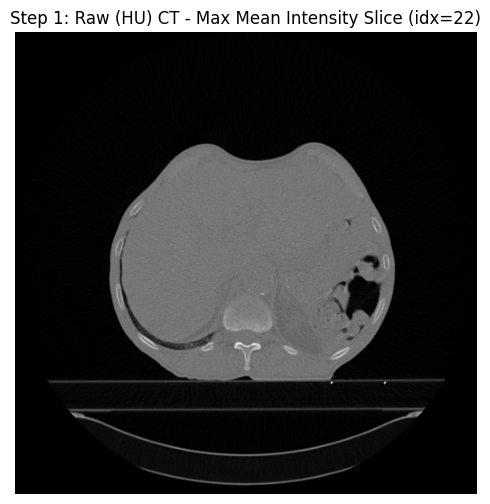

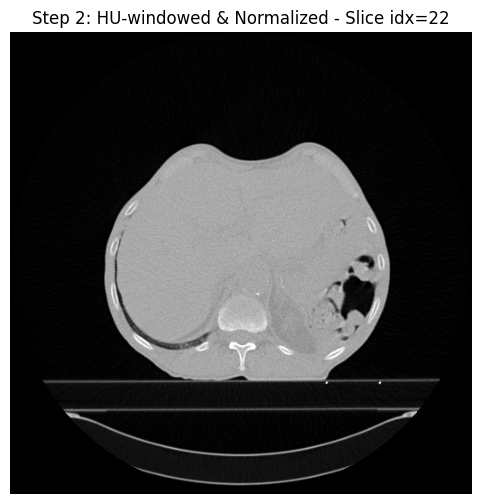

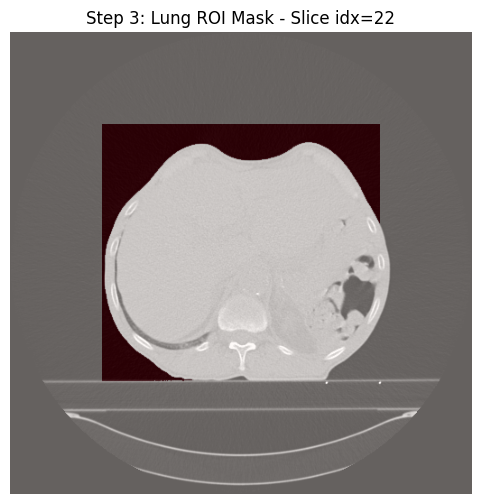

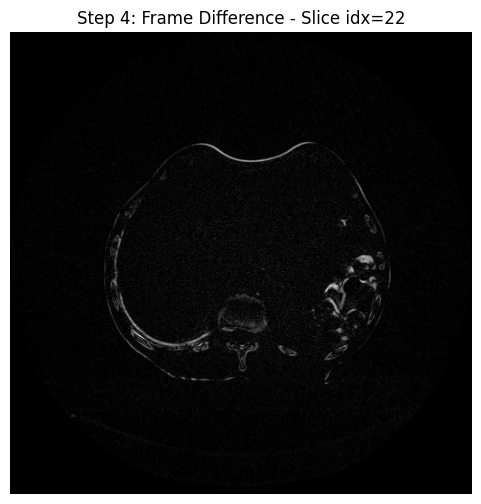

/tmp/ipython-input-15-4161630274.py:98: UserWarning: Glyph 33258 (\N{CJK UNIFIED IDEOGRAPH-81EA}) missing from font(s) DejaVu Sans.
  plt.savefig('step5_tumor_highlight.png', dpi=600, bbox_inches='tight', pad_inches=0)
/tmp/ipython-input-15-4161630274.py:98: UserWarning: Glyph 21160 (\N{CJK UNIFIED IDEOGRAPH-52A8}) missing from font(s) DejaVu Sans.
  plt.savefig('step5_tumor_highlight.png', dpi=600, bbox_inches='tight', pad_inches=0)
/tmp/ipython-input-15-4161630274.py:98: UserWarning: Glyph 39640 (\N{CJK UNIFIED IDEOGRAPH-9AD8}) missing from font(s) DejaVu Sans.
  plt.savefig('step5_tumor_highlight.png', dpi=600, bbox_inches='tight', pad_inches=0)
/tmp/ipython-input-15-4161630274.py:98: UserWarning: Glyph 20142 (\N{CJK UNIFIED IDEOGRAPH-4EAE}) missing from font(s) DejaVu Sans.
  plt.savefig('step5_tumor_highlight.png', dpi=600, bbox_inches='tight', pad_inches=0)
/tmp/ipython-input-15-4161630274.py:98: UserWarning: Glyph 30097 (\N{CJK UNIFIED IDEOGRAPH-7591}) missing from font(s) DejaV

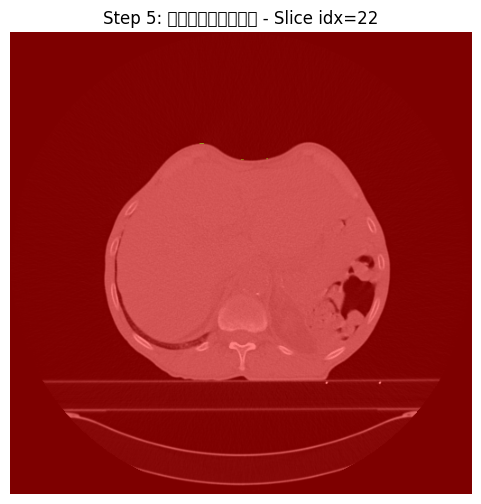

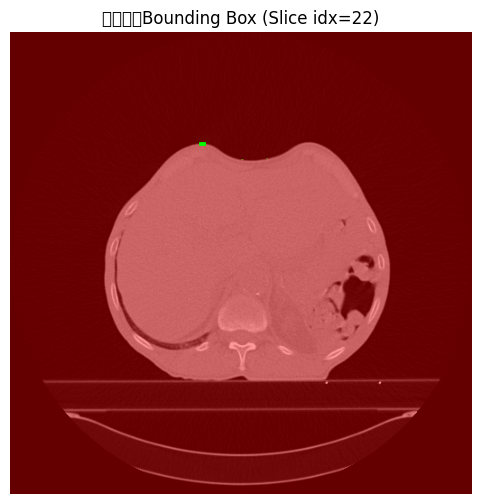

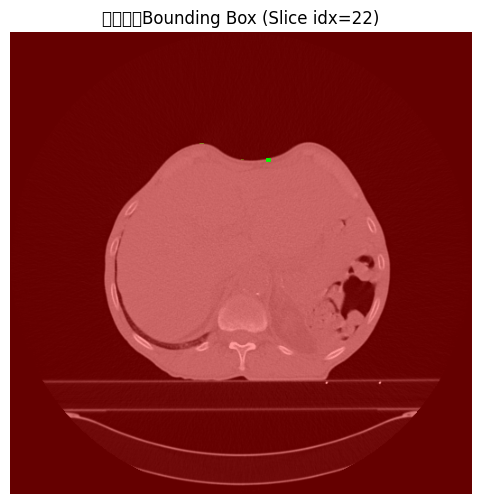

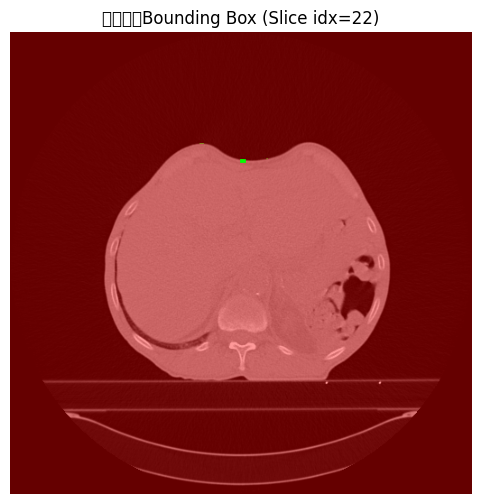

In [15]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import label, binary_fill_holes, find_objects

# 选第一个npy样本
raw_folder = '/content/output_npy1'
npy_list = [f for f in os.listdir(raw_folder) if f.endswith('.npy')]
fname = npy_list[13]   # 你可以改成别的序号
arr = np.load(os.path.join(raw_folder, fname))
if arr.ndim == 2:
    arr = arr[None, ...]   # 兼容单slice

# Step 1. 最大平均密度层
maxidx = arr.mean(axis=(1,2)).argmax()
plt.figure(figsize=(6,6))
plt.imshow(arr[maxidx], cmap='gray')
plt.axis('off')
plt.title(f'Step 1: Raw (HU) CT - Max Mean Intensity Slice (idx={maxidx})')
plt.savefig('step1_raw_maxintensity.png', dpi=600, bbox_inches='tight', pad_inches=0)
plt.show()

# Step 2. 标准肺窗裁剪+归一化
def hu_window_and_normalize(arr, hu_min=-1200, hu_max=600):
    arr_clip = np.clip(arr, hu_min, hu_max)
    arr_norm = (arr_clip - hu_min) / (hu_max - hu_min)
    return arr_norm
arr_norm = hu_window_and_normalize(arr)

plt.figure(figsize=(6,6))
plt.imshow(arr_norm[maxidx], cmap='gray')
plt.axis('off')
plt.title(f'Step 2: HU-windowed & Normalized - Slice idx={maxidx}')
plt.savefig('step2_norm_maxintensity.png', dpi=600, bbox_inches='tight', pad_inches=0)
plt.show()

# Step 3. 肺部掩膜
def extract_lung_mask(slice_arr_norm, hu_thr_norm=0.36, central_ratio=0.6):
    H, W = slice_arr_norm.shape
    h0 = int(H * (1 - central_ratio) / 2)
    h1 = int(H - h0)
    w0 = int(W * (1 - central_ratio) / 2)
    w1 = int(W - w0)
    central_patch = slice_arr_norm[h0:h1, w0:w1]
    mask_central = central_patch < hu_thr_norm
    labeled, n = label(mask_central)
    if n == 0:
        lung_mask_central = np.ones_like(mask_central, dtype=bool)
    else:
        max_label = 1 + np.argmax([np.sum(labeled == i) for i in range(1, n+1)])
        lung_mask_central = labeled == max_label
        lung_mask_central = binary_fill_holes(lung_mask_central)
    mask_full = np.zeros_like(slice_arr_norm, dtype=bool)
    mask_full[h0:h1, w0:w1] = lung_mask_central
    return mask_full

lung_mask = extract_lung_mask(arr_norm[maxidx])
plt.figure(figsize=(6,6))
plt.imshow(arr_norm[maxidx], cmap='gray')
plt.imshow(lung_mask, cmap='Reds', alpha=0.4)
plt.axis('off')
plt.title(f'Step 3: Lung ROI Mask - Slice idx={maxidx}')
plt.savefig('step3_mask_maxintensity.png', dpi=600, bbox_inches='tight', pad_inches=0)
plt.show()

# Step 4. 帧间差分
diff = np.abs(np.diff(arr_norm, axis=0))
diff_pad = np.pad(diff, ((1,0),(0,0),(0,0)), mode='constant')

plt.figure(figsize=(6,6))
plt.imshow(diff_pad[maxidx], cmap='gray')
plt.axis('off')
plt.title(f'Step 4: Frame Difference - Slice idx={maxidx}')
plt.savefig('step4_diff_maxintensity.png', dpi=600, bbox_inches='tight', pad_inches=0)
plt.show()

# Step 5. 自动高亮“疑似肿瘤区”
threshold = 0.12  # 经验阈值，你可微调
high_mask = (diff_pad[maxidx] > threshold) & lung_mask  # 只在肺区内找

# 连通域分析：只保留最大3个连通域，避免误报
labeled, n = label(high_mask)
sizes = [(labeled == i).sum() for i in range(1, n+1)]
if sizes:
    topN = 3
    sorted_ids = np.argsort(sizes)[::-1][:topN] + 1
    final_mask = np.isin(labeled, sorted_ids)
    final_mask = binary_fill_holes(final_mask)
else:
    final_mask = high_mask

# 可视化原图+高亮
plt.figure(figsize=(6,6))
plt.imshow(arr_norm[maxidx], cmap='gray')
plt.imshow(final_mask, cmap='autumn', alpha=0.5)  # 疑似肿瘤高亮
plt.axis('off')
plt.title(f'Step 5: 自动高亮疑似肿瘤区 - Slice idx={maxidx}')
plt.savefig('step5_tumor_highlight.png', dpi=600, bbox_inches='tight', pad_inches=0)
plt.show()

# (可选) 显示bounding box
objs = find_objects(label(final_mask)[0])
for obj in objs:
    if obj is not None:
        plt.figure(figsize=(6,6))
        plt.imshow(arr_norm[maxidx], cmap='gray')
        plt.imshow(final_mask, cmap='autumn', alpha=0.4)
        y0, y1 = obj[0].start, obj[0].stop
        x0, x1 = obj[1].start, obj[1].stop
        plt.gca().add_patch(plt.Rectangle((x0, y0), x1-x0, y1-y0, edgecolor='lime', fill=False, lw=2))
        plt.axis('off')
        plt.title(f'疑似肿瘤Bounding Box (Slice idx={maxidx})')
        plt.show()


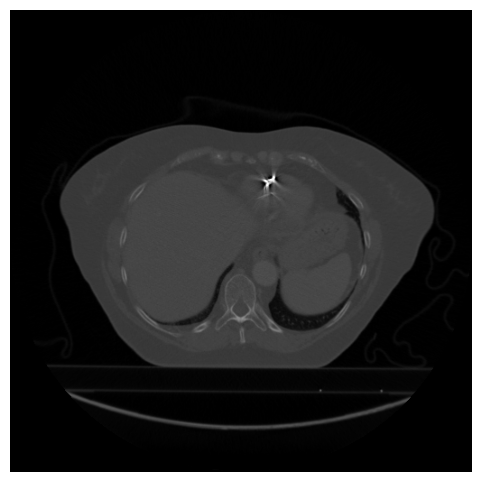

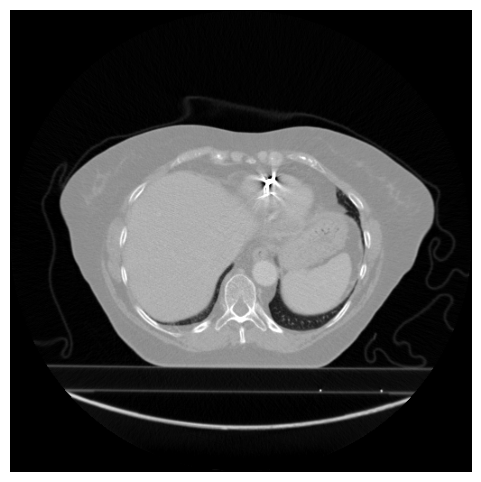

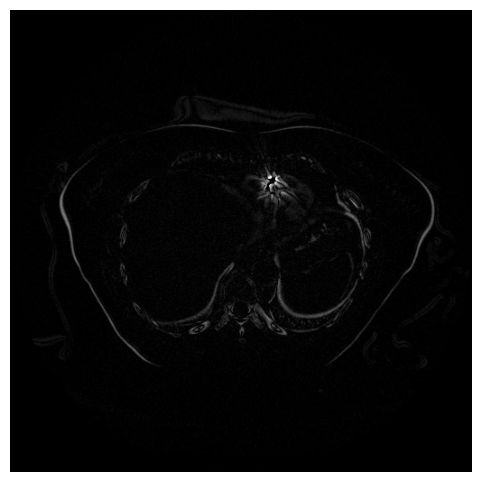

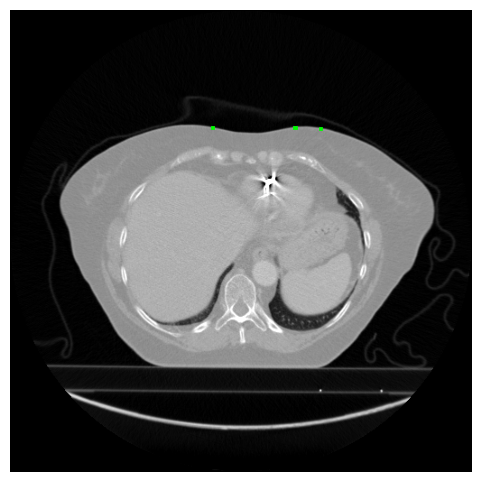

In [42]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import label, binary_fill_holes, find_objects

# 选第一个npy样本
raw_folder = '/content/output_npy1'
npy_list = [f for f in os.listdir(raw_folder) if f.endswith('.npy')]
fname = npy_list[34]   # 你可以改成别的序号
arr = np.load(os.path.join(raw_folder, fname))
if arr.ndim == 2:
    arr = arr[None, ...]   # 兼容单slice

# Step 1. 最大平均密度层
maxidx = arr.mean(axis=(1,2)).argmax()
plt.figure(figsize=(6,6))
plt.imshow(arr[maxidx], cmap='gray')
plt.axis('off')
plt.savefig('step1_raw_maxintensity.png', dpi=600, bbox_inches='tight', pad_inches=0)
plt.show()

# Step 2. 标准肺窗裁剪+归一化
def hu_window_and_normalize(arr, hu_min=-1200, hu_max=600):
    arr_clip = np.clip(arr, hu_min, hu_max)
    arr_norm = (arr_clip - hu_min) / (hu_max - hu_min)
    return arr_norm
arr_norm = hu_window_and_normalize(arr)

plt.figure(figsize=(6,6))
plt.imshow(arr_norm[maxidx], cmap='gray')
plt.axis('off')
plt.savefig('step2_norm_maxintensity.png', dpi=600, bbox_inches='tight', pad_inches=0)
plt.show()

# Step 3. 肺部掩膜（如不想显示红色掩膜可直接略过可视化）
def extract_lung_mask(slice_arr_norm, hu_thr_norm=0.36, central_ratio=0.6):
    H, W = slice_arr_norm.shape
    h0 = int(H * (1 - central_ratio) / 2)
    h1 = int(H - h0)
    w0 = int(W * (1 - central_ratio) / 2)
    w1 = int(W - w0)
    central_patch = slice_arr_norm[h0:h1, w0:w1]
    mask_central = central_patch < hu_thr_norm
    labeled, n = label(mask_central)
    if n == 0:
        lung_mask_central = np.ones_like(mask_central, dtype=bool)
    else:
        max_label = 1 + np.argmax([np.sum(labeled == i) for i in range(1, n+1)])
        lung_mask_central = labeled == max_label
        lung_mask_central = binary_fill_holes(lung_mask_central)
    mask_full = np.zeros_like(slice_arr_norm, dtype=bool)
    mask_full[h0:h1, w0:w1] = lung_mask_central
    return mask_full

lung_mask = extract_lung_mask(arr_norm[maxidx])
# 如不想显示掩膜，这块可直接跳过
# plt.figure(figsize=(6,6))
# plt.imshow(arr_norm[maxidx], cmap='gray')
# plt.imshow(lung_mask, cmap='Reds', alpha=0.4)
# plt.axis('off')
# plt.savefig('step3_mask_maxintensity.png', dpi=600, bbox_inches='tight', pad_inches=0)
# plt.show()

# Step 4. 帧间差分
diff = np.abs(np.diff(arr_norm, axis=0))
diff_pad = np.pad(diff, ((1,0),(0,0),(0,0)), mode='constant')

plt.figure(figsize=(6,6))
plt.imshow(diff_pad[maxidx], cmap='gray')
plt.axis('off')
plt.savefig('step4_diff_maxintensity.png', dpi=600, bbox_inches='tight', pad_inches=0)
plt.show()

# Step 5. 自动高亮“疑似肿瘤区”
threshold = 0.15  # 经验阈值
high_mask = (diff_pad[maxidx] > threshold) & lung_mask  # 只在肺区内找

# 连通域分析：只保留最大3个连通域，避免误报
labeled, n = label(high_mask)
sizes = [(labeled == i).sum() for i in range(1, n+1)]
if sizes:
    topN = 3
    sorted_ids = np.argsort(sizes)[::-1][:topN] + 1
    final_mask = np.isin(labeled, sorted_ids)
    final_mask = binary_fill_holes(final_mask)
else:
    final_mask = high_mask

# 只显示原图+绿色框，无红色掩膜
objs = find_objects(label(final_mask)[0])
plt.figure(figsize=(6,6))
plt.imshow(arr_norm[maxidx], cmap='gray')
for obj in objs:
    if obj is not None:
        y0, y1 = obj[0].start, obj[0].stop
        x0, x1 = obj[1].start, obj[1].stop
        plt.gca().add_patch(
            plt.Rectangle((x0, y0), x1-x0, y1-y0, edgecolor='lime', fill=False, lw=2)
        )
plt.axis('off')
plt.savefig('step5_bbox.png', dpi=600, bbox_inches='tight', pad_inches=0)
plt.show()
